In [1]:
# ===== 1. IMPORT THƯ VIỆN =====
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def train(ticker):
    try:
        df = pd.read_csv(f"E:/Project/StockVNQA_Lâm/train/data/{ticker}.csv")
        
        if len(df) < 60:  # Cần ít nhất 60 dòng dữ liệu
            return None
        
        # Kiểm tra dữ liệu đầu vào
        if 'open' not in df.columns:
            # Không có cột 'open', vẫn sử dụng features hiện tại
            features = ['close', 'volume', 'high', 'low']
        else:
            # Có cột 'open', thêm vào features
            features = ['close', 'open', 'volume', 'high', 'low']
        
        # --- PHẦN 1: TÍNH TOÁN CÁC FEATURES MỚI ---
        # Tạo bản sao để không làm ảnh hưởng đến dữ liệu gốc
        df_features = df.copy()
        
        # KIỂM TRA VÀ XỬ LÝ GIÁ TRỊ KHÔNG HỢP LỆ TRONG DỮ LIỆU GỐC
        # Thay thế các giá trị âm hoặc 0 trong volume bằng giá trị nhỏ
        if (df_features['volume'] <= 0).any():
            min_positive_volume = df_features.loc[df_features['volume'] > 0, 'volume'].min()
            df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
            
        # Đảm bảo giá không có giá trị âm
        for price_col in ['close', 'high', 'low']:
            if (df_features[price_col] <= 0).any():
                print(f"⚠️ {ticker} có giá {price_col} không hợp lệ (âm hoặc bằng 0)")
                return None
        
        # Tính toán các đặc trưng tương đối một cách an toàn
        df_features['daily_return'] = df_features['close'].pct_change().replace([np.inf, -np.inf], np.nan)
        df_features['high_low_range'] = ((df_features['high'] - df_features['low']) / df_features['close']).replace([np.inf, -np.inf], np.nan)
        
        # Nếu có cột open thì tính thêm đặc trưng close_to_open
        if 'open' in df.columns:
            df_features['close_to_open'] = ((df_features['close'] - df_features['open']) / df_features['open']).replace([np.inf, -np.inf], np.nan)
        
        # Tính toán các chỉ báo trung bình động
        df_features['ma5'] = df_features['close'].rolling(window=5).mean()
        df_features['ma20'] = df_features['close'].rolling(window=20).mean()
        
        # Xử lý trường hợp chia cho 0 hoặc NaN
        ma5 = df_features['ma5']
        ma20 = df_features['ma20']
        mask = (ma20 != 0) & ma20.notnull() & ma5.notnull()
        df_features['ma_ratio'] = np.nan
        df_features.loc[mask, 'ma_ratio'] = ma5.loc[mask] / ma20.loc[mask]
        
        # Tính toán độ biến động (volatility) an toàn
        df_features['volatility_5d'] = df_features['daily_return'].rolling(window=5).std().replace([np.inf, -np.inf], np.nan)
        
        # Phân tích khối lượng
        df_features['volume_ma5'] = df_features['volume'].rolling(window=5).mean()
        
        # Xử lý trường hợp chia cho 0 hoặc NaN
        vol = df_features['volume']
        vol_ma5 = df_features['volume_ma5']
        mask = (vol_ma5 != 0) & vol_ma5.notnull() & vol.notnull()
        df_features['volume_ratio'] = np.nan
        df_features.loc[mask, 'volume_ratio'] = vol.loc[mask] / vol_ma5.loc[mask]
        
        # Xử lý giá trị thiếu từ việc tính toán các chỉ báo - sửa warning
        df_features = df_features.ffill()  # Thay vì fillna(method='ffill')
        df_features = df_features.fillna(0)  # Điền 0 cho các giá trị NaN còn lại ở đầu
        
        # --- PHẦN 2: CHUẨN BỊ DỮ LIỆU ĐẦU VÀO ---
        # Danh sách các đặc trưng sẽ sử dụng, bao gồm cả đặc trưng gốc và đặc trưng mới
        extended_features = features.copy()  # Giữ các đặc trưng gốc
        
        # Thêm các đặc trưng mới đã tính toán
        additional_features = [
            'daily_return', 'high_low_range', 'ma_ratio', 
            'volatility_5d', 'volume_ratio'
        ]
        
        # Thêm close_to_open nếu có dữ liệu open
        if 'open' in df.columns:
            additional_features.append('close_to_open')
            
        # Kết hợp tất cả đặc trưng và kiểm tra giá trị không hợp lệ
        for feat in additional_features:
            if feat in df_features.columns:  # Chỉ thêm feature nếu tồn tại
                # Kiểm tra giá trị không hợp lệ
                if df_features[feat].isnull().any() or np.isinf(df_features[feat]).any():
                    print(f"⚠️ {ticker} có giá trị NaN hoặc Inf trong feature {feat}. Thay thế bằng 0.")
                    df_features[feat] = df_features[feat].replace([np.inf, -np.inf], 0).fillna(0)
                extended_features.append(feat)
        
        # KIỂM TRA LẦN CUỐI TRƯỚC KHI CHUẨN HÓA
        # Thay thế bất kỳ giá trị không hợp lệ còn lại
        df_check = df_features[extended_features]
        if df_check.isnull().any().any() or np.isinf(df_check).any().any():
            print(f"⚠️ {ticker} vẫn có giá trị không hợp lệ. Làm sạch dữ liệu...")
            df_check = df_check.replace([np.inf, -np.inf], 0)
            df_check = df_check.fillna(0)
            df_features[extended_features] = df_check
        
        # Chuẩn hóa tất cả đặc trưng
        scaler = MinMaxScaler()
        try:
            scaled_data = scaler.fit_transform(df_features[extended_features])
        except Exception as scale_error:
            print(f"❌ {ticker} - Lỗi khi chuẩn hóa dữ liệu: {str(scale_error)}")
            # Hiển thị thêm thông tin để debug
            print(f"Kiểm tra giá trị không hợp lệ: {df_features[extended_features].describe()}")
            return None

        # --- PHẦN 3: TẠO CHUỖI DỮ LIỆU CHO LSTM ---
        def create_dataset(data, window_size=30):
            X, y = [], []
            for i in range(len(data) - window_size):
                X.append(data[i:i+window_size])
                y.append(data[i+window_size, 0])  # Vẫn dự đoán close (cột đầu tiên)
            return np.array(X), np.array(y)

        window_size = 30
        X, y = create_dataset(scaled_data, window_size)

        # --- PHẦN 4: CHIA DỮ LIỆU TRAIN/TEST ---
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # --- PHẦN 5: XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH ---
        model = Sequential()
        model.add(LSTM(64, input_shape=(window_size, X.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        # --- PHẦN 6: DỰ ĐOÁN VÀ ĐÁNH GIÁ ---
        y_pred = model.predict(X_test)
        
        # Chuyển đổi giá trị về thang đo gốc
        # Tạo mảng với giá trị dự đoán ở vị trí đầu tiên và 0 ở các vị trí còn lại
        y_pred_full = np.zeros((len(y_pred), len(extended_features)))
        y_pred_full[:, 0] = y_pred.flatten()  # Đặt giá trị dự đoán vào cột đầu tiên (close)
        
        # Tương tự với giá trị thực tế
        y_test_full = np.zeros((len(y_test), len(extended_features)))
        y_test_full[:, 0] = y_test  # Đặt giá trị thực tế vào cột đầu tiên (close)
        
        # Inverse transform để lấy giá trị gốc
        y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]
        y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

        # Tính RMSE
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        
        # Tính R²
        r2 = r2_score(y_test_inv, y_pred_inv)
        
        # Tính Direction Accuracy
        start_idx = window_size + split
        actual_current_prices = df['close'].values[start_idx:start_idx+len(y_test_inv)-1]
        
        # Đảm bảo các mảng có cùng kích thước
        min_len = min(len(y_test_inv)-1, len(actual_current_prices))
        
        # Tính hướng giá thực tế và dự đoán, chỉ dùng phần chồng lấp
        actual_direction = (y_test_inv[1:min_len+1] > actual_current_prices[:min_len]).astype(int)
        predicted_direction = (y_pred_inv[1:min_len+1] > actual_current_prices[:min_len]).astype(int)
        
        # Tính direction accuracy
        direction_accuracy = np.mean(actual_direction == predicted_direction)
        
        # --- PHẦN 7: DỰ ĐOÁN GIÁ CHO NGÀY TIẾP THEO ---
        last_seq = scaled_data[-window_size:]
        last_seq = last_seq.reshape((1, window_size, len(extended_features)))
        next_day_scaled = model.predict(last_seq)
        
        # Tạo mảng đầy đủ để inverse transform
        next_day_full = np.zeros((1, len(extended_features)))
        next_day_full[0, 0] = next_day_scaled[0, 0]  # Đặt giá trị dự đoán vào cột đầu tiên
        
        next_day_price = scaler.inverse_transform(next_day_full)[0][0]
        
        # Tính % thay đổi
        current_price = df['close'].iloc[-1]
        change_pct = ((next_day_price - current_price) / current_price) * 100
        
        # Tùy chọn: Vẽ biểu đồ so sánh giá thực tế và dự đoán
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(y_test_inv, label='Giá thực tế', marker='o', markersize=3, alpha=0.7)
            plt.plot(y_pred_inv, label='Giá dự đoán', marker='x', markersize=3)
            plt.title(f'Dự đoán giá {ticker} bằng LSTM (RMSE: {rmse:.4f}, R²: {r2:.4f})')
            plt.xlabel('Ngày kiểm tra')
            plt.ylabel('Giá đóng cửa')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            import os
            # os.makedirs("E:/Project/StockVNQA_Lâm/train/charts", exist_ok=True)
            # plt.savefig(f"E:/Project/StockVNQA_Lâm/train/charts/{ticker}_prediction.png")
            plt.show()
            plt.close()
        except Exception as chart_error:
            print(f"⚠️ Không thể vẽ biểu đồ cho {ticker}: {str(chart_error)}")
        
        return {
            'ticker': ticker,
            'total_days': len(df),
            'train_days': len(y_train),
            'test_days': len(y_test),
            'rmse': rmse,
            'r2': r2,
            'direction_accuracy': direction_accuracy,
            'current_price': current_price,
            'predicted_price': next_day_price,
            'change_pct': change_pct,
            'trend': 'UP' if change_pct > 0 else 'DOWN'
        }
        
    except Exception as e:
        print(f"❌ Lỗi xử lý {ticker} với LSTM: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


import json
def load_tickers_from_file(filename, base_path="E:/Project/StockVNQA_Lâm/train/"):
    file_path = os.path.join(base_path, filename)
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]
    






In [4]:
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from vnstock import Vnstock


def train_LSTM_enhanced(ticker, test_size=0.2, val_size=0.1):
    """
    Train mô hình LSTM cho dự đoán giá cổ phiếu sử dụng tất cả dữ liệu có sẵn
    
    Args:
        ticker (str): Mã cổ phiếu
        test_size (float): Tỷ lệ dữ liệu test
        val_size (float): Tỷ lệ dữ liệu validation
    Returns:
        dict: Kết quả train và đánh giá mô hình
    """
    try:
        # Set up logging
        import logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        logger = logging.getLogger(f"LSTM-{ticker}")
        
        logger.info(f"Bắt đầu huấn luyện LSTM cho {ticker} sử dụng tất cả dữ liệu có sẵn")
        
        # 1. Lấy dữ liệu lịch sử
        end_date = datetime.now()
        end_date_str = end_date.strftime('%Y-%m-%d')
        start_date = '2000-01-01'  # Lấy dữ liệu từ lâu đời
        
        logger.info(f"Đang lấy dữ liệu từ {start_date} đến {end_date_str}")
        
        # Thử các phương thức API khác nhau
        from vnstock import Quote
        quote = Quote(symbol=ticker)
        df = quote.history(start = '2000-01-01', end= end_date_str, interval='1D')
        
        # 2. Kiểm tra dữ liệu
        if df is None or df.empty or len(df) < 60:
            logger.error(f"Không đủ dữ liệu cho {ticker}: chỉ có {0 if df is None else len(df)} dòng")
            return None
            
        # Sắp xếp theo thời gian nếu cần
        if 'time' in df.columns or 'date' in df.columns:
            date_col = 'time' if 'time' in df.columns else 'date'
            df[date_col] = pd.to_datetime(df[date_col])
            df = df.sort_values(by=date_col)
        
        logger.info(f"Đã lấy được {len(df)} ngày dữ liệu cho {ticker}")
        
        # 3. Xác định các features cơ bản
        if 'open' not in df.columns:
            features = ['close', 'volume', 'high', 'low']
        else:
            features = ['close', 'open', 'volume', 'high', 'low']
        
        # 4. Feature Engineering và Xử lý dữ liệu
        df_features = df.copy()
        
        # Xử lý volume bất thường
        if (df_features['volume'] <= 0).any():
            min_positive_volume = df_features.loc[df_features['volume'] > 0, 'volume'].min()
            df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
            logger.warning(f"Đã điều chỉnh {(df_features['volume'] <= 0).sum()} giá trị volume không hợp lệ")
            
        # Kiểm tra giá âm hoặc bằng 0
        for price_col in ['close', 'high', 'low']:
            if (df_features[price_col] <= 0).any():
                logger.error(f"Phát hiện giá trị giá không hợp lệ trong cột {price_col}")
                return None
        
        # Tính toán các chỉ báo kỹ thuật
        # Returns và Volatility
        df_features['daily_return'] = df_features['close'].pct_change().replace([np.inf, -np.inf], np.nan)
        df_features['high_low_range'] = ((df_features['high'] - df_features['low']) / df_features['close']).replace([np.inf, -np.inf], np.nan)
        
        if 'open' in df.columns:
            df_features['close_to_open'] = ((df_features['close'] - df_features['open']) / df_features['open']).replace([np.inf, -np.inf], np.nan)
        
        # Moving Averages
        df_features['ma5'] = df_features['close'].rolling(window=5).mean()
        df_features['ma20'] = df_features['close'].rolling(window=20).mean()
        
        # Moving Average Ratio
        ma5 = df_features['ma5']
        ma20 = df_features['ma20']
        mask = (ma20 != 0) & ma20.notnull() & ma5.notnull()
        df_features['ma_ratio'] = np.nan
        df_features.loc[mask, 'ma_ratio'] = ma5.loc[mask] / ma20.loc[mask]
        
        # Volatility
        df_features['volatility_5d'] = df_features['daily_return'].rolling(window=5).std().replace([np.inf, -np.inf], np.nan)
        
        # Volume Indicators
        df_features['volume_ma5'] = df_features['volume'].rolling(window=5).mean()
        
        # Volume Ratio
        vol = df_features['volume']
        vol_ma5 = df_features['volume_ma5']
        mask = (vol_ma5 != 0) & vol_ma5.notnull() & vol.notnull()
        df_features['volume_ratio'] = np.nan
        df_features.loc[mask, 'volume_ratio'] = vol.loc[mask] / vol_ma5.loc[mask]
        
        # RSI - Relative Strength Index
        delta = df_features['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss.replace(0, 0.001)  # Tránh chia cho 0
        df_features['rsi'] = 100 - (100 / (1 + rs))
        
        # MACD - Moving Average Convergence Divergence
        df_features['ema12'] = df_features['close'].ewm(span=12, adjust=False).mean()
        df_features['ema26'] = df_features['close'].ewm(span=26, adjust=False).mean()
        df_features['macd'] = df_features['ema12'] - df_features['ema26']
        df_features['macd_signal'] = df_features['macd'].ewm(span=9, adjust=False).mean()
        
        # Xử lý missing values
        df_features = df_features.ffill()  # forward fill
        df_features = df_features.fillna(0)  # các giá trị NaN còn lại
        
        # 5. Kết hợp các features
        extended_features = features.copy()  
        
        # Các features bổ sung
        additional_features = [
            'daily_return', 'high_low_range', 'ma_ratio', 
            'volatility_5d', 'volume_ratio', 'rsi', 'macd', 'macd_signal'
        ]
        
        if 'open' in df.columns:
            additional_features.append('close_to_open')
        
        # Kiểm tra và thêm features
        for feat in additional_features:
            if feat in df_features.columns:  
                if df_features[feat].isnull().any() or np.isinf(df_features[feat]).any():
                    df_features[feat] = df_features[feat].replace([np.inf, -np.inf], 0).fillna(0)
                extended_features.append(feat)
        
        # Kiểm tra cuối cùng các giá trị không hợp lệ
        df_check = df_features[extended_features]
        if df_check.isnull().any().any() or np.isinf(df_check).any().any():
            df_check = df_check.replace([np.inf, -np.inf], 0)
            df_check = df_check.fillna(0)
            df_features[extended_features] = df_check
        
        # 6. Chuẩn hóa dữ liệu
        scaler = MinMaxScaler()
        try:
            scaled_data = scaler.fit_transform(df_features[extended_features])
        except Exception as scale_error:
            logger.error(f"Lỗi khi chuẩn hóa dữ liệu: {str(scale_error)}")
            return None

        # 7. Tạo dữ liệu chuỗi thời gian
        window_size = 30  # Giữ nguyên window_size = 30 như trong code gốc
        
        def create_dataset(data, window_size=30):
            X, y = [], []
            for i in range(len(data) - window_size):
                X.append(data[i:i+window_size])
                y.append(data[i+window_size, 0])  # Dự đoán giá đóng cửa
            return np.array(X), np.array(y)

        X, y = create_dataset(scaled_data, window_size)
        
        # Kiểm tra đủ dữ liệu cho train/val/test
        if len(X) < 60:  # yêu cầu tối thiểu
            logger.error(f"Không đủ dữ liệu sau khi tạo chuỗi: chỉ có {len(X)} mẫu")
            return None

        # 8. Phân chia train/validation/test
        train_size = int(len(X) * (1 - test_size - val_size))
        val_size_samples = int(len(X) * val_size)
        
        X_train = X[:train_size]
        y_train = y[:train_size]
        
        X_val = X[train_size:train_size+val_size_samples]
        y_val = y[train_size:train_size+val_size_samples]
        
        X_test = X[train_size+val_size_samples:]
        y_test = y[train_size+val_size_samples:]
        
        logger.info(f"Phân chia dữ liệu: Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)} mẫu")

        # 9. Xây dựng và huấn luyện mô hình
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        from tensorflow.keras.layers import Dropout, BatchNormalization
        
        # Kiến trúc nâng cao với dropout và batch normalization
        model = Sequential()
        model.add(LSTM(64, input_shape=(window_size, X.shape[2]), return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(LSTM(32))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        ]
        
        # Huấn luyện mô hình với validation data
        logger.info("Bắt đầu huấn luyện mô hình LSTM")
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,  # giữ nguyên số epochs=50 như code gốc
            batch_size=16,
            callbacks=callbacks,
            verbose=0
        )
        
        # 10. Đánh giá mô hình
        logger.info("Đánh giá mô hình trên tập test")
        y_pred = model.predict(X_test)
        
        # Chuyển đổi về thang đo gốc
        y_pred_full = np.zeros((len(y_pred), len(extended_features)))
        y_pred_full[:, 0] = y_pred.flatten()
        
        y_test_full = np.zeros((len(y_test), len(extended_features)))
        y_test_full[:, 0] = y_test
        
        y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]
        y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

        # Tính các metrics
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        r2 = r2_score(y_test_inv, y_pred_inv)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        
        # Tính direction accuracy
        start_idx = window_size + train_size + val_size_samples
        actual_current_prices = df['close'].values[start_idx:start_idx+len(y_test_inv)-1]
        
        min_len = min(len(y_test_inv)-1, len(actual_current_prices))
        
        actual_direction = (y_test_inv[1:min_len+1] > actual_current_prices[:min_len]).astype(int)
        predicted_direction = (y_pred_inv[1:min_len+1] > actual_current_prices[:min_len]).astype(int)
        
        direction_accuracy = np.mean(actual_direction == predicted_direction)
        
        # 11. Dự đoán giá cho ngày tiếp theo
        last_seq = scaled_data[-window_size:]
        last_seq = last_seq.reshape((1, window_size, len(extended_features)))
        next_day_scaled = model.predict(last_seq)
        
        next_day_full = np.zeros((1, len(extended_features)))
        next_day_full[0, 0] = next_day_scaled[0, 0]
        
        next_day_price = scaler.inverse_transform(next_day_full)[0][0]
        
        current_price = df['close'].iloc[-1]
        change_pct = ((next_day_price - current_price) / current_price) * 100
        
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_inv, label='Giá thực tế', marker='o', markersize=3, alpha=0.7)
        plt.plot(y_pred_inv, label='Giá dự đoán', marker='x', markersize=3)
        plt.title(f'Dự đoán giá {ticker} bằng LSTM (RMSE: {rmse:.4f}, R²: {r2:.4f})')
        plt.xlabel('Ngày kiểm tra')
        plt.ylabel('Giá đóng cửa')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        # plt.show()
        
        # 12. Kết quả trả về
        result = {
            'ticker': ticker,
            'total_days': len(df),
            'train_days': len(X_train),
            'val_days': len(X_val),
            'test_days': len(X_test),
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'direction_accuracy': direction_accuracy,
            'current_price': current_price,
            'predicted_price': next_day_price,
            'change_pct': change_pct,
            'trend': 'UP' if change_pct > 0 else 'DOWN'
        }
        
        logger.info(f"Kết quả dự đoán cho {ticker}: RMSE={rmse:.4f}, R²={r2:.4f}, Trend={'UP' if change_pct > 0 else 'DOWN'} ({change_pct:.2f}%)")
        return result
        
    except Exception as e:
        logging.error(f"❌ Lỗi xử lý {ticker} với LSTM: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


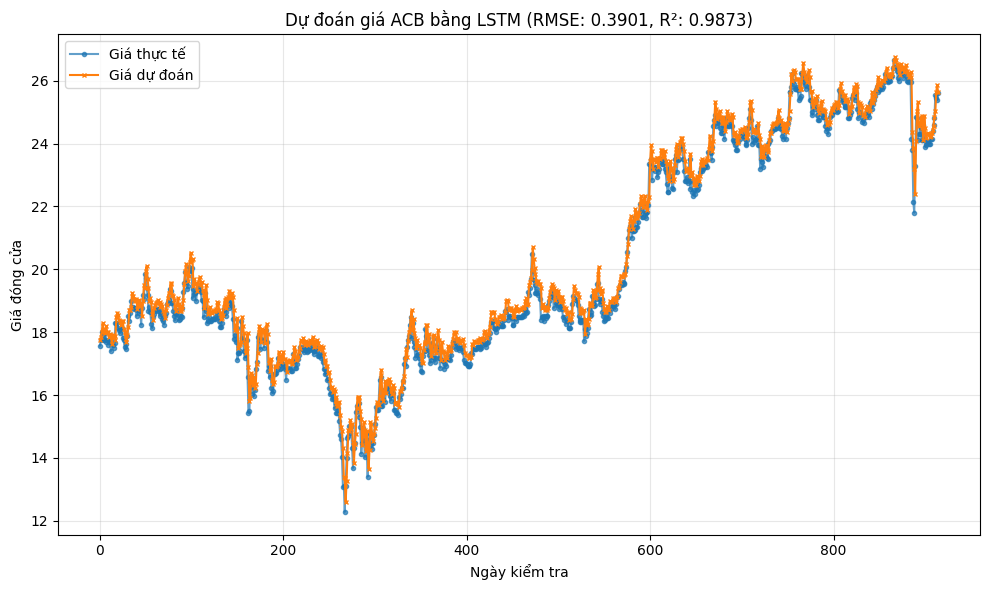

{'ticker': 'ACB', 'total_days': 4605, 'train_days': 3660, 'test_days': 915, 'rmse': np.float64(0.390097400120408), 'r2': 0.9873223316604892, 'direction_accuracy': np.float64(0.4726477024070022), 'current_price': np.float64(25.6), 'predicted_price': np.float64(25.84890850067139), 'change_pct': np.float64(0.972298830747606), 'trend': 'UP'}


In [5]:
print(train("ACB"))

2025-05-22 23:14:15,679 - INFO - Bắt đầu huấn luyện LSTM cho ACB sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:14:15,681 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:14:15,682 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:14:15,970 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:14:15,977 - INFO - Đã lấy được 4607 ngày dữ liệu cho ACB
2025-05-22 23:14:16,007 - INFO - Phân chia dữ liệu: Train: 3203, Val: 457, Test: 917 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:14:16,079 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:14:57,925 - INFO - Đánh giá mô hình trên tập test


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


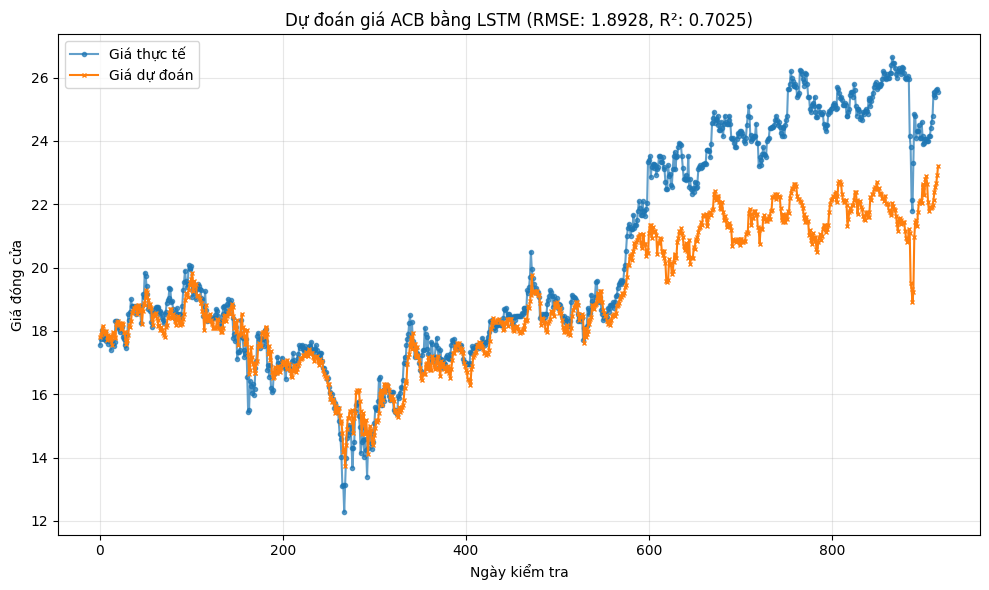

2025-05-22 23:14:58,747 - INFO - Kết quả dự đoán cho ACB: RMSE=1.8928, R²=0.7025, Trend=DOWN (-9.37%)


{'ticker': 'ACB', 'data_days': 4607, 'train_days': 3203, 'val_days': 457, 'test_days': 917, 'rmse': np.float64(1.8927728289611094), 'mae': 1.2993569818161823, 'r2': 0.7024881020362888, 'direction_accuracy': np.float64(0.5251091703056768), 'current_price': np.float64(25.55), 'predicted_price': np.float64(23.156837005615234), 'change_pct': np.float64(-9.366587062171298), 'trend': 'DOWN'}


In [8]:
print(train_LSTM_enhanced("ACB", 0.2, 0.1))

R2 TICKERS THẤP NHẤT (THEO XGBOOST)

['TMB', 'DDG', 'AAT', 'RCD', 'GH3', 'BSA', 'THM', 'HTR', 'FRT', 'SBG']


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


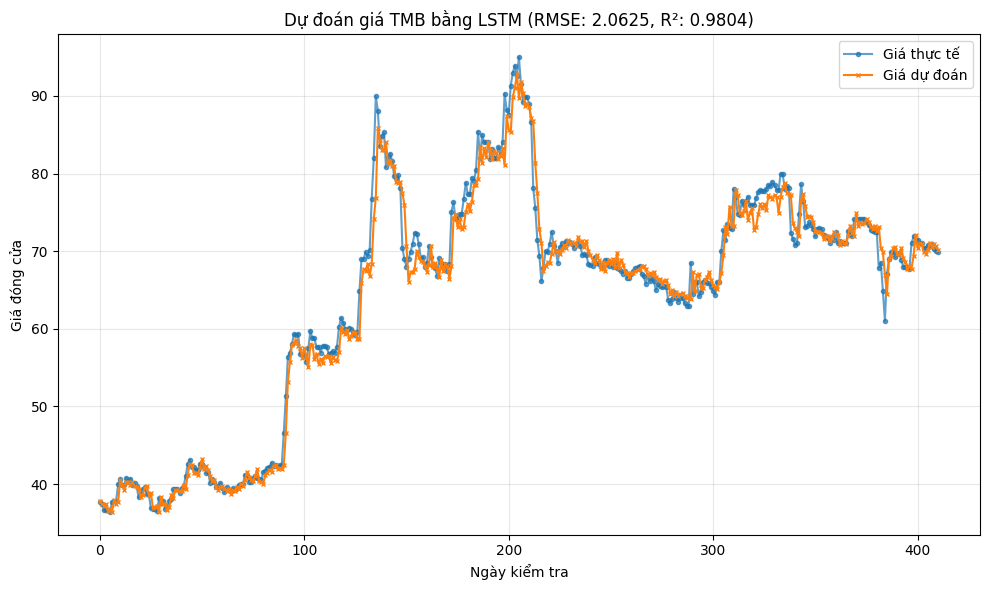

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


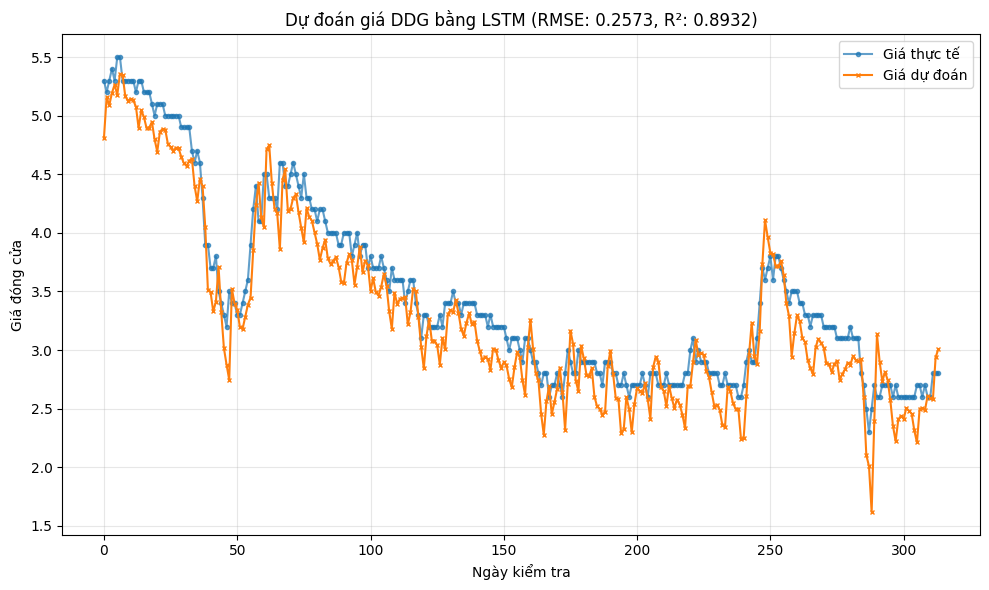

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


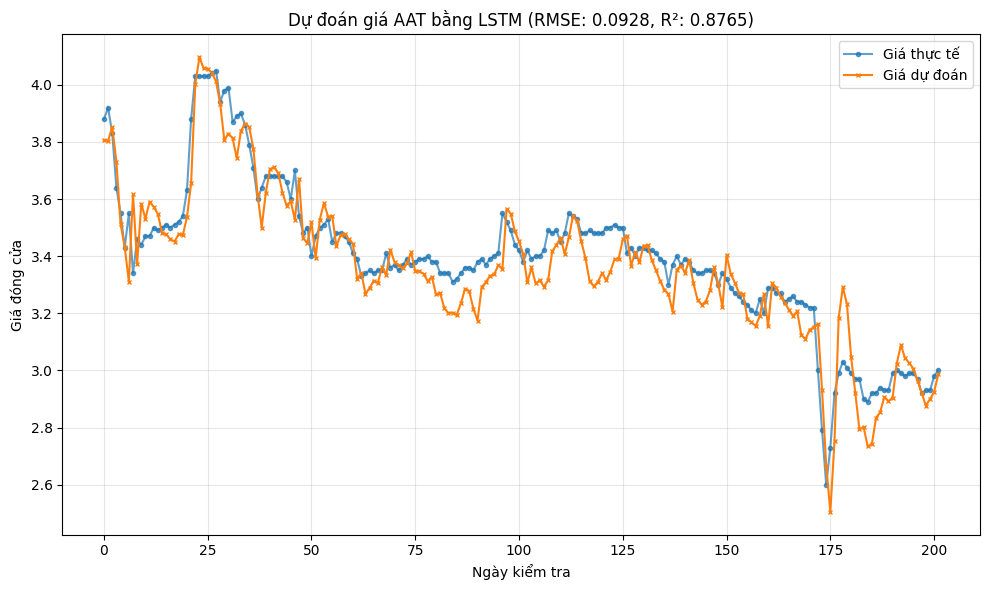

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


⚠️ RCD có giá close không hợp lệ (âm hoặc bằng 0)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


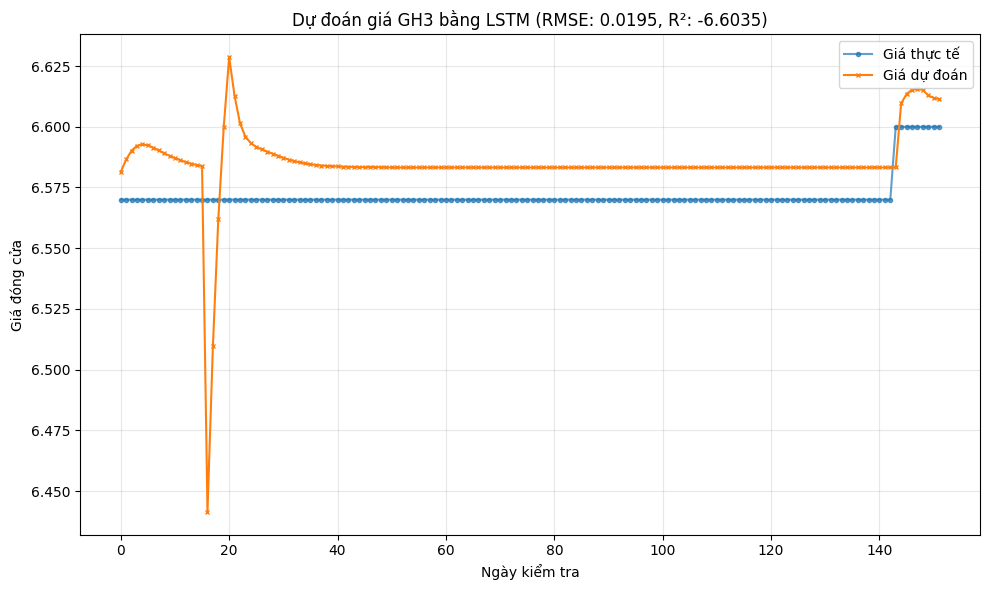

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


2025-05-22 23:06:56,362 - WARNING - 5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C013902660> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


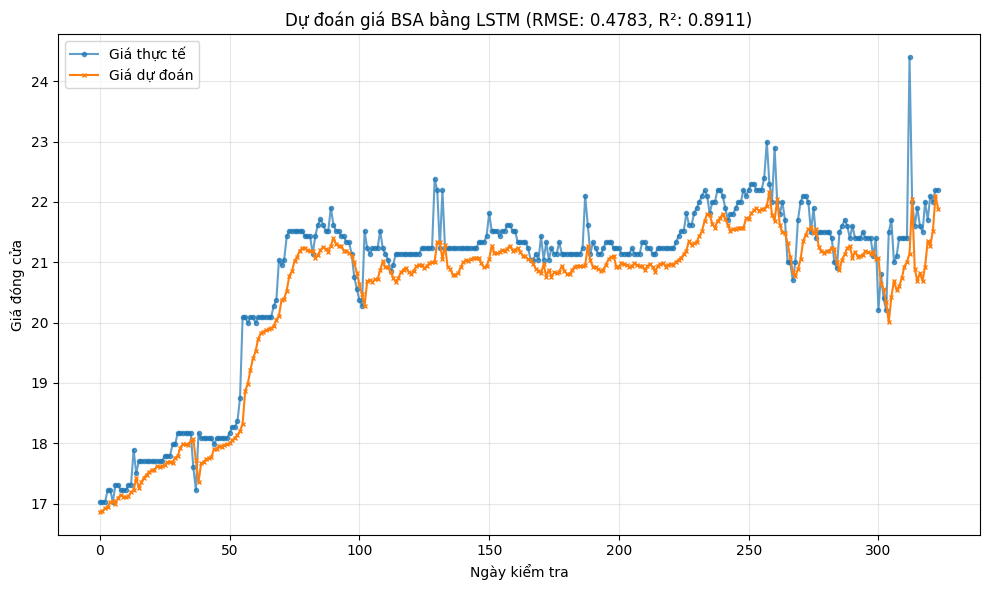

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


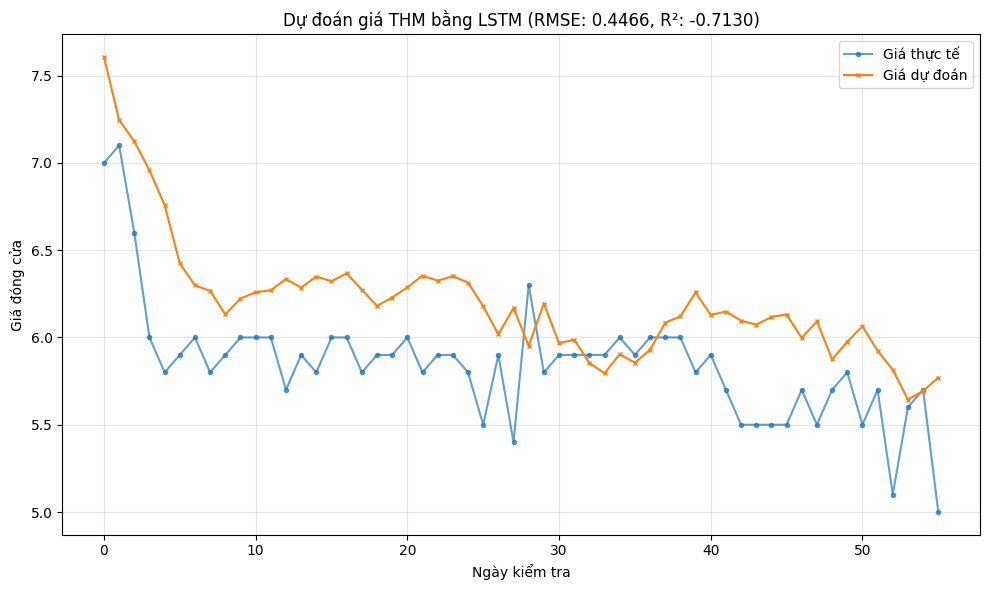

⚠️ HTR có giá close không hợp lệ (âm hoặc bằng 0)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


2025-05-22 23:07:29,014 - WARNING - 5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C012E99440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


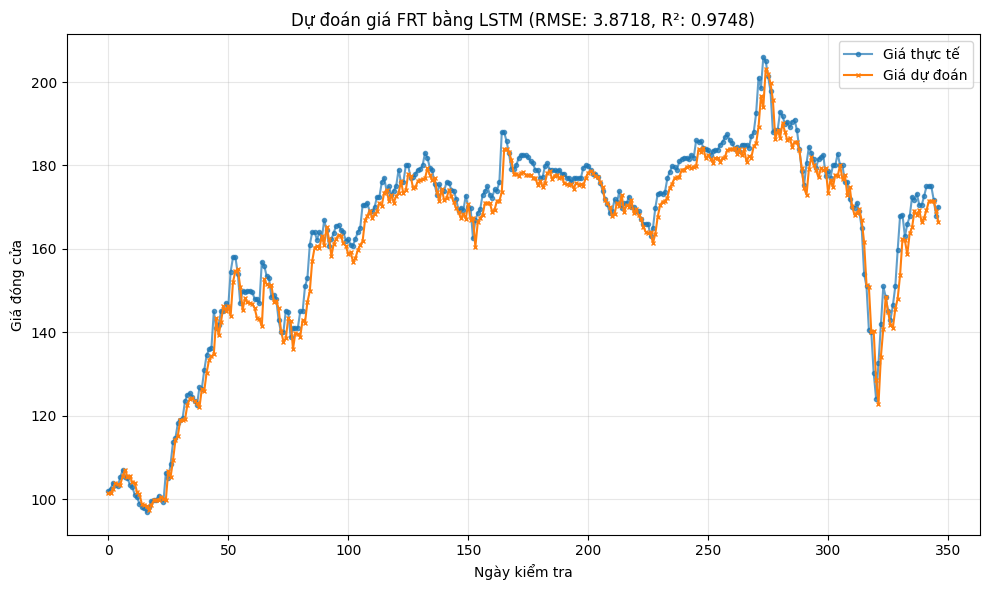

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


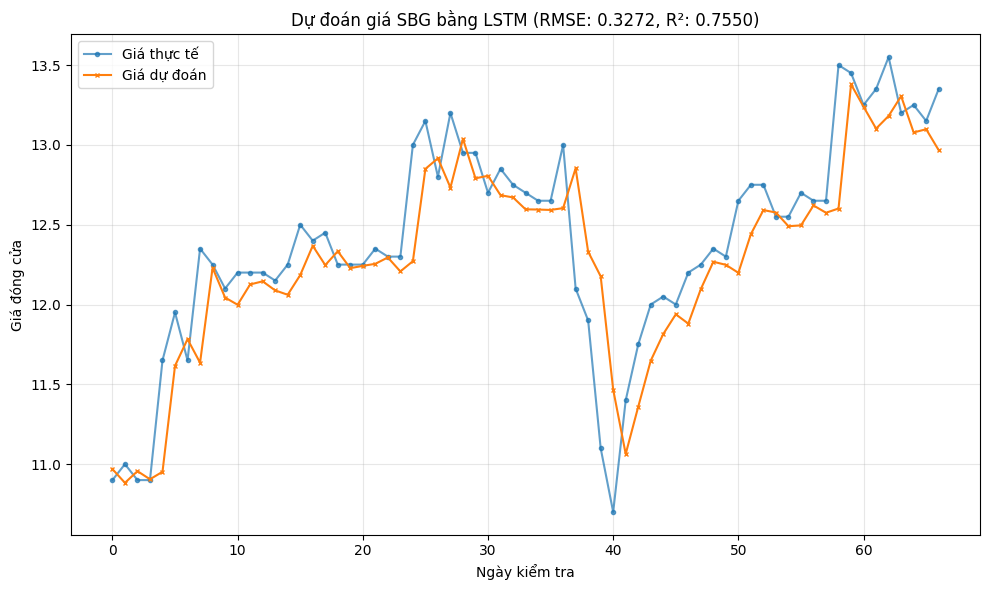


=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 8
R² trung bình: -0.2432
RMSE trung bình: 0.9445
Độ chính xác dự đoán hướng trung bình: 0.4980
  ticker      rmse        r2  direction_accuracy  total_days  train_days  \
0    TMB  2.062493  0.980426            0.529268        2081        1640   
1    DDG  0.257338  0.893210            0.642173        1599        1255   
2    AAT  0.092754  0.876505            0.522388        1036         804   
3    GH3  0.019524 -6.603502            0.026490         790         608   
4    BSA  0.478322  0.891143            0.696594        1650        1296   
5    THM  0.446587 -0.712982            0.472727         306         220   
6    FRT  3.871814  0.974793            0.549133        1764        1387   
7    SBG  0.327240  0.755049            0.545455         361         264   

   test_days  
0        411  
1        314  
2        202  
3        152  
4        324  
5         56  
6        347  
7         67  
9587
7474
1873


In [32]:
results = []

bottom_r2_tickers = load_tickers_from_file("bottom_r2_tickers.txt")
print(bottom_r2_tickers)
for ticker in bottom_r2_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'train_days', 'test_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

2025-05-22 23:19:23,674 - INFO - Bắt đầu huấn luyện LSTM cho TMB sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:19:23,675 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:19:23,676 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...


['TMB', 'DDG', 'AAT', 'RCD', 'GH3', 'BSA', 'THM', 'HTR', 'FRT', 'SBG']


2025-05-22 23:19:24,014 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:19:24,017 - INFO - Đã lấy được 2083 ngày dữ liệu cho TMB
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-22 23:19:24,019 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-22 23:19:24,036 - INFO - Phân chia dữ liệu: Train: 1437, Val: 205, Test: 411 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:19:24,092 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:19:45,546 - INFO - Đánh giá mô hình trên tập test


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


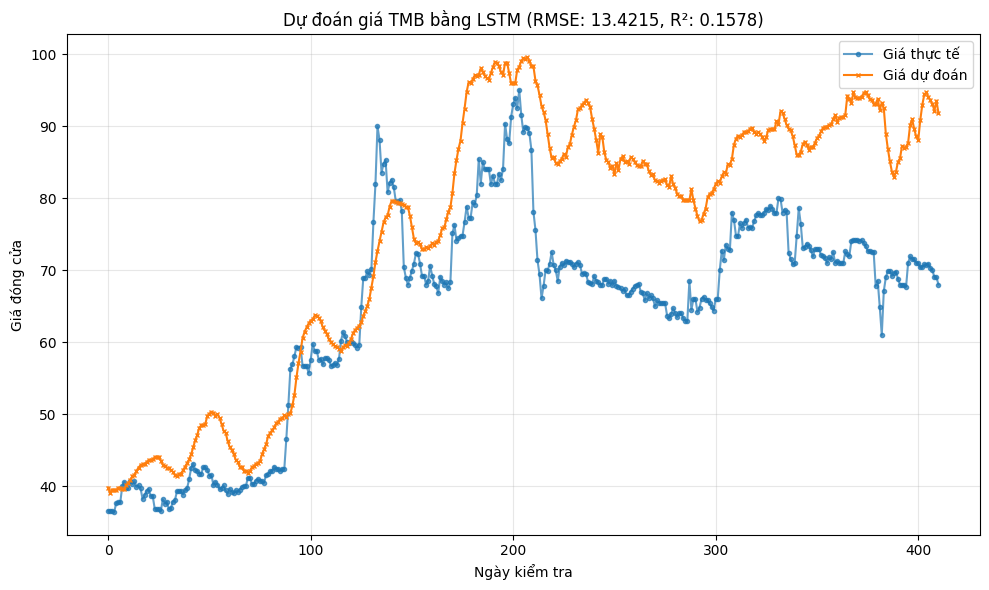

2025-05-22 23:19:46,311 - INFO - Kết quả dự đoán cho TMB: RMSE=13.4215, R²=0.1578, Trend=UP (33.06%)
2025-05-22 23:19:46,312 - INFO - Bắt đầu huấn luyện LSTM cho DDG sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:19:46,312 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:19:46,314 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:19:46,631 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:19:46,633 - INFO - Đã lấy được 1601 ngày dữ liệu cho DDG
2025-05-22 23:19:46,654 - INFO - Phân chia dữ liệu: Train: 1099, Val: 157, Test: 315 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:19:46,710 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:20:12,218 - INFO - Đánh giá mô hình trên tập test


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


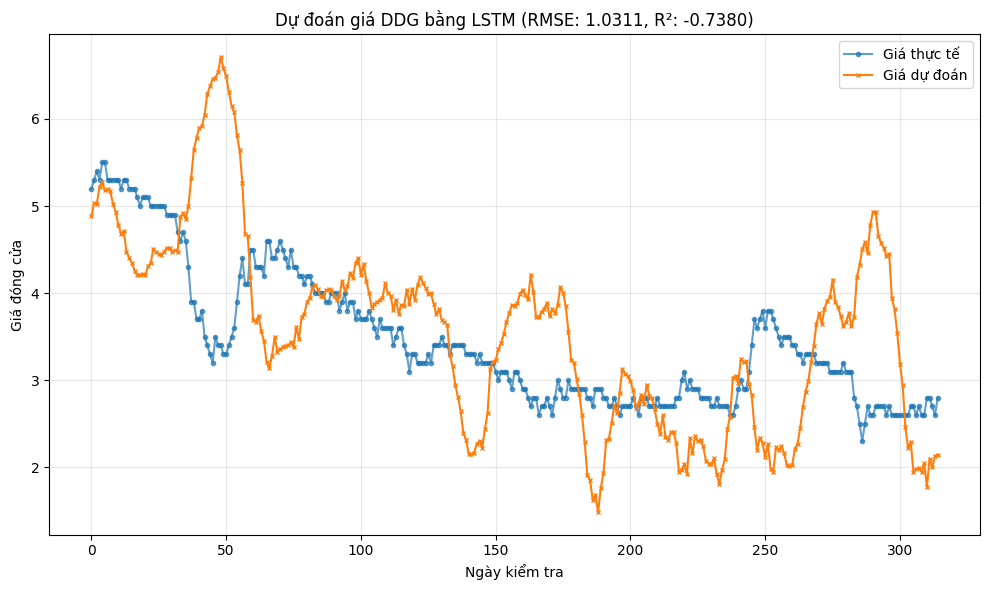

2025-05-22 23:20:13,146 - INFO - Kết quả dự đoán cho DDG: RMSE=1.0311, R²=-0.7380, Trend=DOWN (-28.98%)
2025-05-22 23:20:13,147 - INFO - Bắt đầu huấn luyện LSTM cho AAT sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:20:13,149 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:20:13,149 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:20:13,419 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:20:13,423 - INFO - Đã lấy được 1038 ngày dữ liệu cho AAT
2025-05-22 23:20:13,441 - INFO - Phân chia dữ liệu: Train: 705, Val: 100, Test: 203 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:20:13,500 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:20:36,139 - INFO - Đánh giá mô hình trên tập test


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


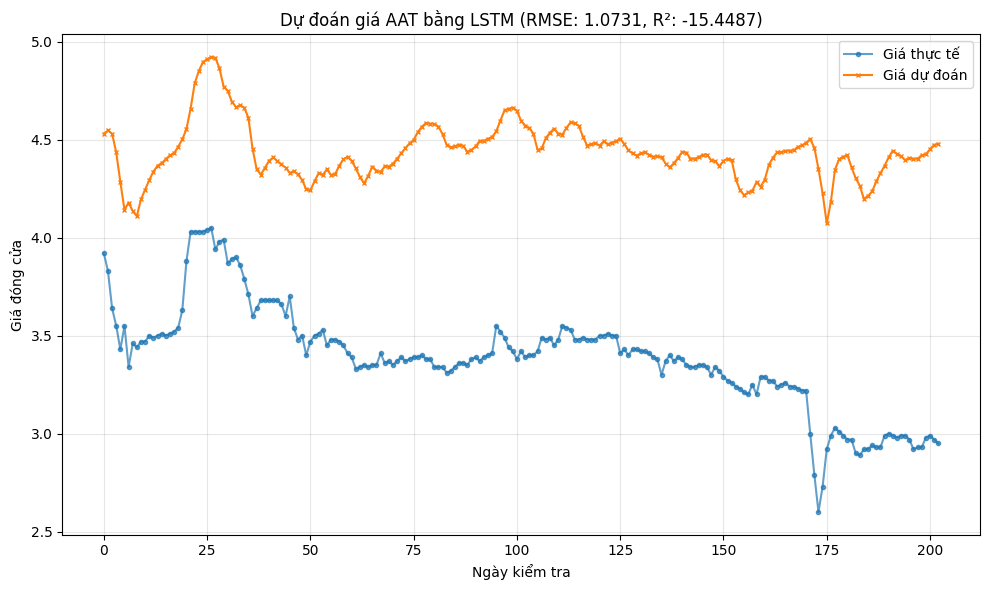

2025-05-22 23:20:36,953 - INFO - Kết quả dự đoán cho AAT: RMSE=1.0731, R²=-15.4487, Trend=UP (51.79%)
2025-05-22 23:20:36,955 - INFO - Bắt đầu huấn luyện LSTM cho RCD sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:20:36,956 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:20:36,956 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:20:37,272 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:20:37,275 - INFO - Đã lấy được 2398 ngày dữ liệu cho RCD
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-22 23:20:37,278 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-22 23:20:37,278 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-22 23:20:37,279 - INFO - Bắt đầu huấn luyện LSTM cho GH3 sử dụng tất cả dữ liệu có sẵn
2025-

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


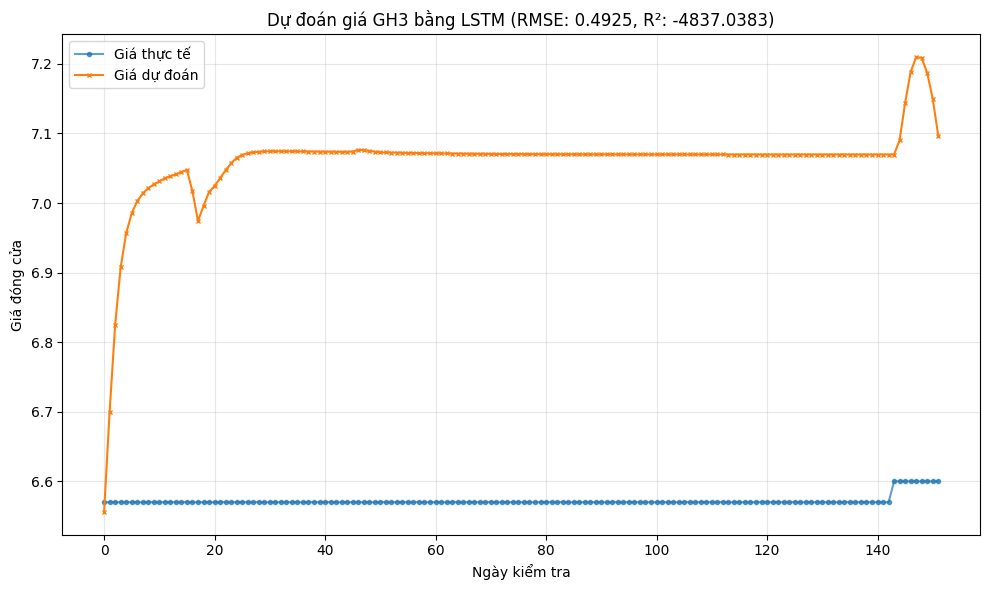

2025-05-22 23:21:01,447 - INFO - Kết quả dự đoán cho GH3: RMSE=0.4925, R²=-4837.0383, Trend=UP (6.42%)
2025-05-22 23:21:01,448 - INFO - Bắt đầu huấn luyện LSTM cho BSA sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:21:01,449 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:21:01,449 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:21:01,692 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:21:01,694 - INFO - Đã lấy được 1652 ngày dữ liệu cho BSA
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-22 23:21:01,697 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-22 23:21:01,715 - INFO - Phân chia dữ liệu: Train: 1135, Val: 162, Test: 325 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pre

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


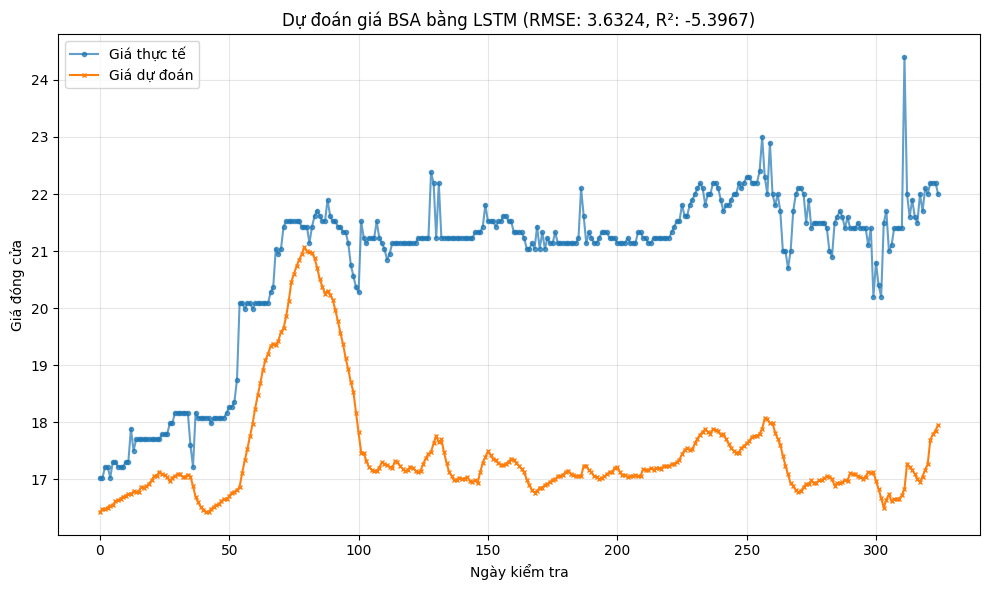

2025-05-22 23:21:26,079 - INFO - Kết quả dự đoán cho BSA: RMSE=3.6324, R²=-5.3967, Trend=DOWN (-18.39%)
2025-05-22 23:21:26,081 - INFO - Bắt đầu huấn luyện LSTM cho THM sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:21:26,081 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:21:26,082 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:21:26,261 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:21:26,264 - INFO - Đã lấy được 308 ngày dữ liệu cho THM
2025-05-22 23:21:26,265 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-22 23:21:26,281 - INFO - Phân chia dữ liệu: Train: 194, Val: 27, Test: 57 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:21:26,337 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:21:34,263 - INFO - Đánh giá mô hình trên tập test


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


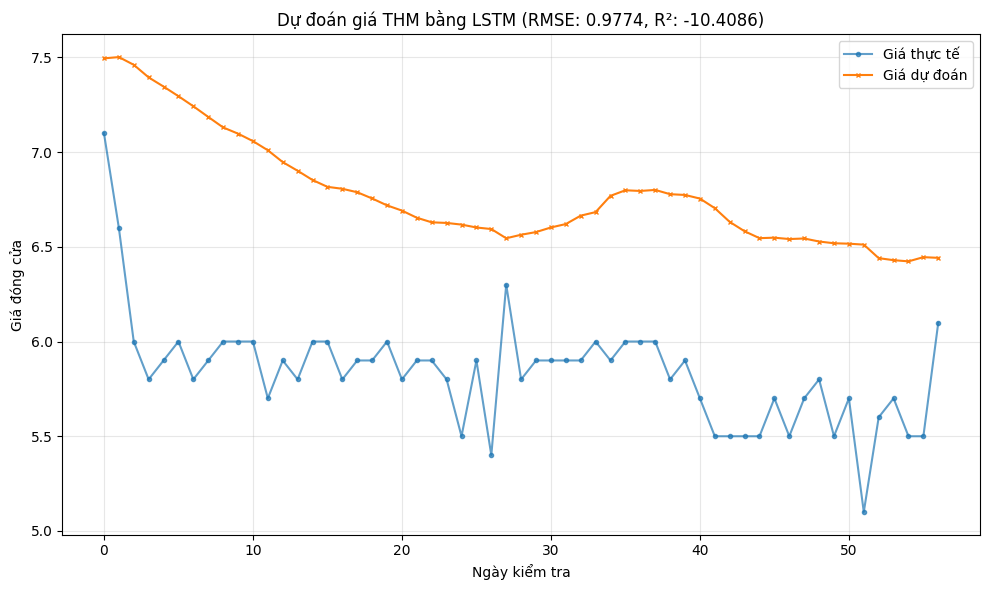

2025-05-22 23:21:35,017 - INFO - Kết quả dự đoán cho THM: RMSE=0.9774, R²=-10.4086, Trend=UP (6.39%)
2025-05-22 23:21:35,018 - INFO - Bắt đầu huấn luyện LSTM cho HTR sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:21:35,020 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:21:35,020 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:21:35,225 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:21:35,227 - INFO - Đã lấy được 1574 ngày dữ liệu cho HTR
2025-05-22 23:21:35,229 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-22 23:21:35,230 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-22 23:21:35,231 - INFO - Bắt đầu huấn luyện LSTM cho FRT sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:21:35,232 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:21:35,232 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:21:35,4

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


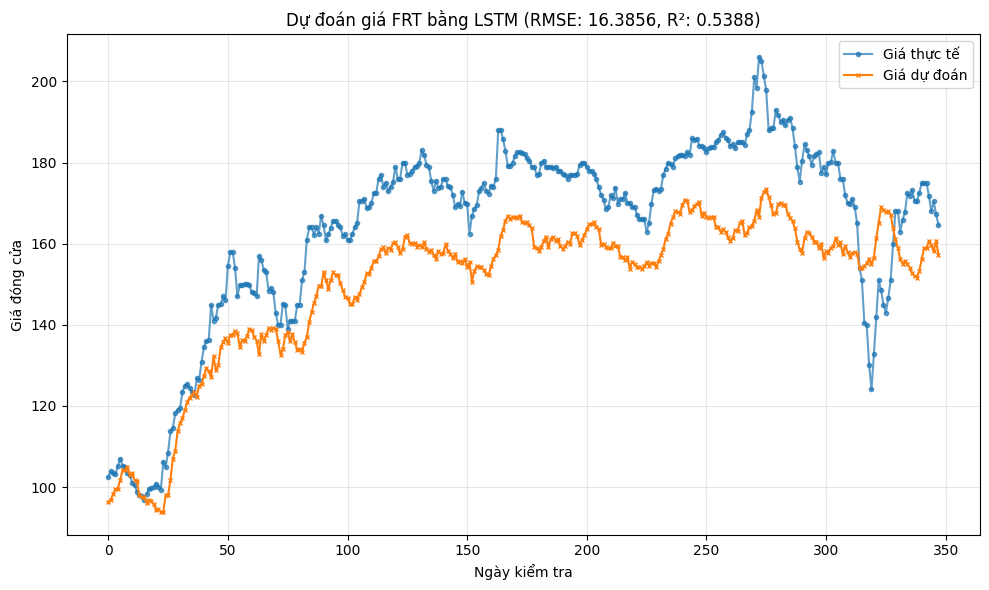

2025-05-22 23:21:56,935 - INFO - Kết quả dự đoán cho FRT: RMSE=16.3856, R²=0.5388, Trend=DOWN (-5.59%)
2025-05-22 23:21:56,936 - INFO - Bắt đầu huấn luyện LSTM cho SBG sử dụng tất cả dữ liệu có sẵn
2025-05-22 23:21:56,936 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-22
2025-05-22 23:21:56,937 - WARNING - API mới thất bại: 'NoneType' object is not callable, thử phương pháp khác...
2025-05-22 23:21:57,141 - INFO - Lấy dữ liệu thành công bằng API cũ
2025-05-22 23:21:57,143 - INFO - Đã lấy được 363 ngày dữ liệu cho SBG
2025-05-22 23:21:57,160 - INFO - Phân chia dữ liệu: Train: 233, Val: 33, Test: 67 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-22 23:21:57,211 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-22 23:22:09,081 - INFO - Đánh giá mô hình trên tập test


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


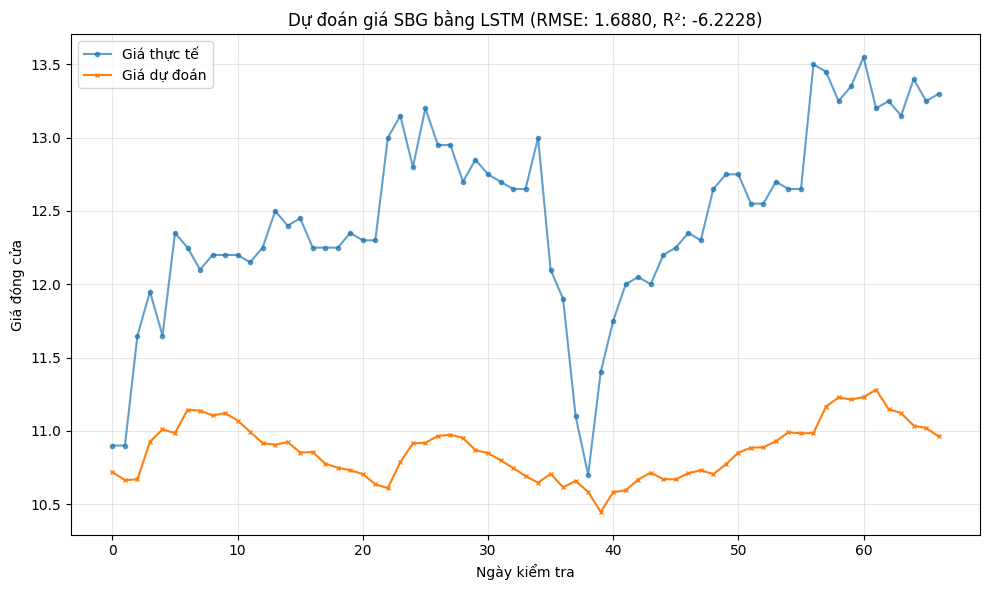

2025-05-22 23:22:09,766 - INFO - Kết quả dự đoán cho SBG: RMSE=1.6880, R²=-6.2228, Trend=DOWN (-17.72%)



=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 8
R² trung bình: -609.3196
RMSE trung bình: 4.8377
Độ chính xác dự đoán hướng trung bình: 0.4471
  ticker       rmse           r2  direction_accuracy  total_days  train_days  \
0    TMB  13.421491     0.157821            0.417073        2083        1437   
1    DDG   1.031111    -0.738034            0.592357        1601        1099   
2    AAT   1.073135   -15.448651            0.391089        1038         705   
3    GH3   0.492495 -4837.038296            0.006623         790         532   
4    BSA   3.632363    -5.396655            0.703704        1652        1135   
5    THM   0.977368   -10.408625            0.392857         308         194   
6    FRT  16.385648     0.538756            0.527378        1766        1215   
7    SBG   1.687971    -6.222815            0.545455         363         233   

   test_days  
0        411  
1        315  
2        203  
3        152  
4        325  
5         57  
6        348  
7      

In [11]:
results = []

bottom_r2_tickers = load_tickers_from_file("bottom_r2_tickers.txt")
print(bottom_r2_tickers)
for ticker in bottom_r2_tickers:
    result = train_LSTM_enhanced(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'train_days', 'test_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

R2 TICKERS CAO NHẤT

In [16]:
results = []

top_r2_tickers = load_tickers_from_file("top_r2_tickers.txt")
print(top_r2_tickers)
for ticker in top_r2_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy','total_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

['DTL', 'TSC', 'TTF', 'VC2', 'S27', 'TBX', 'HTL', 'SRA', 'KMR', 'CVN']


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 10
R² trung bình: 0.8835
RMSE trung bình: 0.3459
Độ chính xác dự đoán hướng trung bình: 0.5515
  ticker      rmse        r2  direction_accuracy  total_days
0    DTL  0.529572  0.996462            0.462483        3698
1    TSC  0.250044  0.996529            0.580275        4392
2    TTF  0.235822  0.995327            0.450820        4303
3    VC2  0.839480  0.996566            0.595838        4596
4    S27  0.198108  0.995330            0.407225        3076
5    TBX  0.247334 -0.116616            0.989704        3919
6    HTL  0.506987  0.994458            0.399154        3577
7    SRA  0.221267  0.994088            0.564593        4214
8    KMR  0.144852  0.991210            0.613636        4215
9    CVN  0.285215  0.991590            0.450867        3495
39485
31344
7841


2025-05-23 10:16:31,247 - INFO - Bắt đầu huấn luyện LSTM cho DTL sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:16:31,248 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23


['DTL', 'TSC', 'TTF', 'VC2', 'S27', 'TBX', 'HTL', 'SRA', 'KMR', 'CVN']


2025-05-23 10:16:31,755 - INFO - Đã lấy được 3700 ngày dữ liệu cho DTL
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:16:31,758 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:16:31,778 - INFO - Phân chia dữ liệu: Train: 2569, Val: 367, Test: 734 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:16:31,833 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:17:47,984 - INFO - Đánh giá mô hình trên tập test


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-23 10:17:48,657 - INFO - Kết quả dự đoán cho DTL: RMSE=0.7813, R²=0.9921, Trend=DOWN (-2.20%)
2025-05-23 10:17:48,657 - INFO - Bắt đầu huấn luyện LSTM cho TSC sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:17:48,657 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:17:49,027 - INFO - Đã lấy được 4395 ngày dữ liệu cho TSC
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:17:49,027 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:17:49,053 - INFO - Phân chia dữ liệu: Train: 3055, Val: 436, Test: 874 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:17:49,105 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:18:34,059 - INFO - Đánh giá 

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-05-23 10:18:34,786 - INFO - Kết quả dự đoán cho TSC: RMSE=0.5895, R²=0.9806, Trend=UP (9.06%)
2025-05-23 10:18:34,788 - INFO - Bắt đầu huấn luyện LSTM cho TTF sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:18:34,789 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:18:35,206 - INFO - Đã lấy được 4306 ngày dữ liệu cho TTF
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:18:35,207 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:18:35,232 - INFO - Phân chia dữ liệu: Train: 2993, Val: 427, Test: 856 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:18:35,288 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:20:01,498 - INFO - Đánh giá mô 

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-05-23 10:20:02,211 - INFO - Kết quả dự đoán cho TTF: RMSE=0.4329, R²=0.9842, Trend=UP (15.95%)
2025-05-23 10:20:02,216 - INFO - Bắt đầu huấn luyện LSTM cho VC2 sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:20:02,216 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:20:02,587 - INFO - Đã lấy được 4599 ngày dữ liệu cho VC2
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:20:02,589 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:20:02,613 - INFO - Phân chia dữ liệu: Train: 3198, Val: 456, Test: 915 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:20:02,667 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:21:01,002 - INFO - Đánh giá m

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2025-05-23 10:21:01,716 - INFO - Kết quả dự đoán cho VC2: RMSE=1.7800, R²=0.9845, Trend=UP (33.50%)
2025-05-23 10:21:01,718 - INFO - Bắt đầu huấn luyện LSTM cho S27 sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:21:01,719 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:21:01,977 - INFO - Đã lấy được 3076 ngày dữ liệu cho S27
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:21:01,980 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:21:01,998 - INFO - Phân chia dữ liệu: Train: 2132, Val: 304, Test: 610 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:21:02,048 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:21:53,179 - INFO - Đánh giá mô

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-23 10:21:54,259 - INFO - Kết quả dự đoán cho S27: RMSE=0.4268, R²=0.9783, Trend=UP (50.94%)
2025-05-23 10:21:54,259 - INFO - Bắt đầu huấn luyện LSTM cho TBX sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:21:54,259 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:21:54,578 - INFO - Đã lấy được 3919 ngày dữ liệu cho TBX
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:21:54,580 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:21:54,605 - INFO - Phân chia dữ liệu: Train: 2722, Val: 388, Test: 779 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:21:54,654 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:22:23,959 - INFO - Đánh giá m

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2025-05-23 10:22:24,767 - INFO - Kết quả dự đoán cho TBX: RMSE=0.4011, R²=-1.9397, Trend=UP (27.28%)
2025-05-23 10:22:24,767 - INFO - Bắt đầu huấn luyện LSTM cho HTL sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:22:24,776 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:22:25,269 - INFO - Đã lấy được 3579 ngày dữ liệu cho HTL
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:22:25,272 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:22:25,302 - INFO - Phân chia dữ liệu: Train: 2484, Val: 354, Test: 711 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:22:25,360 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:23:25,779 - INFO - Đánh giá 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-23 10:23:26,590 - INFO - Kết quả dự đoán cho HTL: RMSE=0.7353, R²=0.9884, Trend=UP (0.48%)
2025-05-23 10:23:26,591 - INFO - Bắt đầu huấn luyện LSTM cho SRA sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:23:26,592 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:23:26,968 - INFO - Đã lấy được 4215 ngày dữ liệu cho SRA
2025-05-23 10:23:26,973 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:23:27,001 - INFO - Phân chia dữ liệu: Train: 2929, Val: 418, Test: 838 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:23:27,055 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:25:07,057 - INFO - Đánh giá mô hình trên tập test


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2025-05-23 10:25:07,777 - INFO - Kết quả dự đoán cho SRA: RMSE=0.3294, R²=0.9869, Trend=UP (28.70%)
2025-05-23 10:25:07,779 - INFO - Bắt đầu huấn luyện LSTM cho KMR sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:25:07,779 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:25:08,292 - INFO - Đã lấy được 4217 ngày dữ liệu cho KMR
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:25:08,294 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:25:08,323 - INFO - Phân chia dữ liệu: Train: 2930, Val: 418, Test: 839 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:25:08,372 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:25:47,871 - INFO - Đánh giá mô

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2025-05-23 10:25:48,578 - INFO - Kết quả dự đoán cho KMR: RMSE=0.2378, R²=0.9763, Trend=DOWN (-1.79%)
2025-05-23 10:25:48,578 - INFO - Bắt đầu huấn luyện LSTM cho CVN sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:25:48,578 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:25:48,902 - INFO - Đã lấy được 3495 ngày dữ liệu cho CVN
2025-05-23 10:25:48,904 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:25:48,931 - INFO - Phân chia dữ liệu: Train: 2425, Val: 346, Test: 694 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:25:48,984 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:26:17,970 - INFO - Đánh giá mô hình trên tập test


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2025-05-23 10:26:18,647 - INFO - Kết quả dự đoán cho CVN: RMSE=0.3946, R²=0.9839, Trend=UP (11.68%)



=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 10
R² trung bình: 0.6916
RMSE trung bình: 0.6108
Độ chính xác dự đoán hướng trung bình: 0.3988
  ticker      rmse        r2  direction_accuracy  total_days
0    DTL  0.781255  0.992052            0.493861        3700
1    TSC  0.589475  0.980551            0.420389        4395
2    TTF  0.432871  0.984196            0.445614        4306
3    VC2  1.779953  0.984547            0.416849        4599
4    S27  0.426807  0.978322            0.308703        3076
5    TBX  0.401053 -1.939662            0.000000        3919
6    HTL  0.735292  0.988418            0.516901        3579
7    SRA  0.329427  0.986886            0.366786        4215
8    KMR  0.237758  0.976281            0.483294        4217
9    CVN  0.394588  0.983917            0.535354        3495
39501
27437
7850


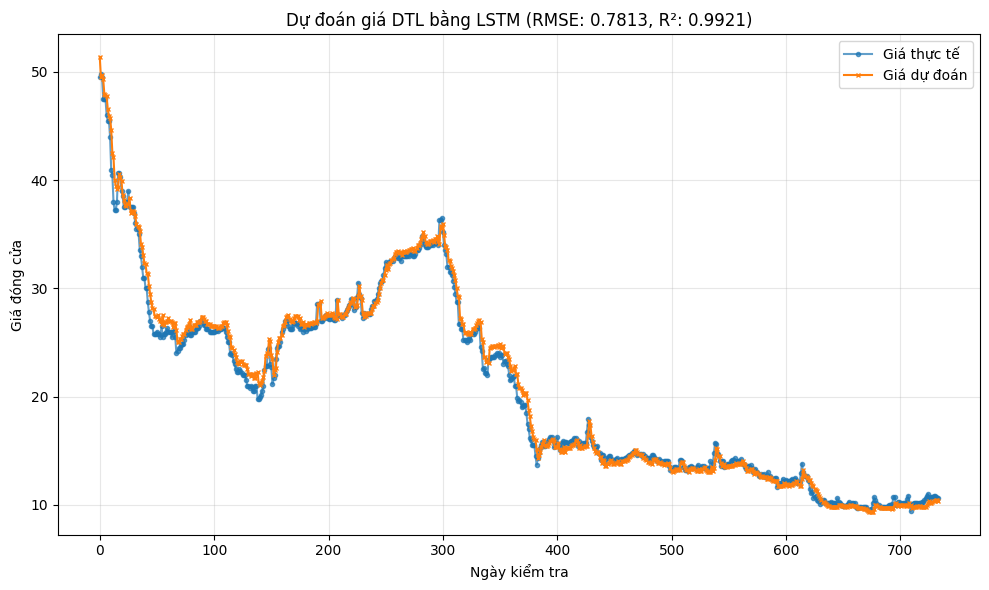

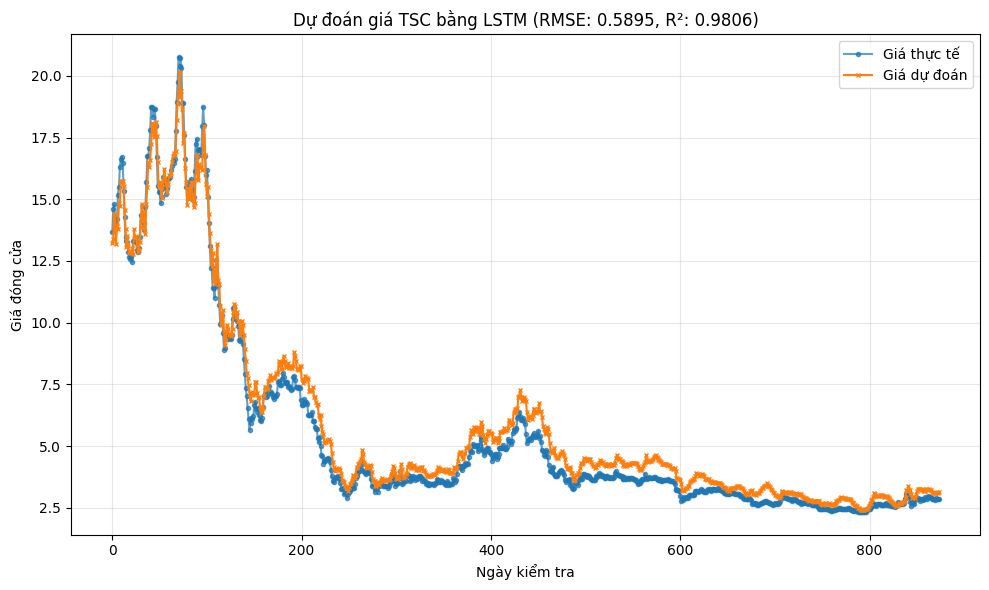

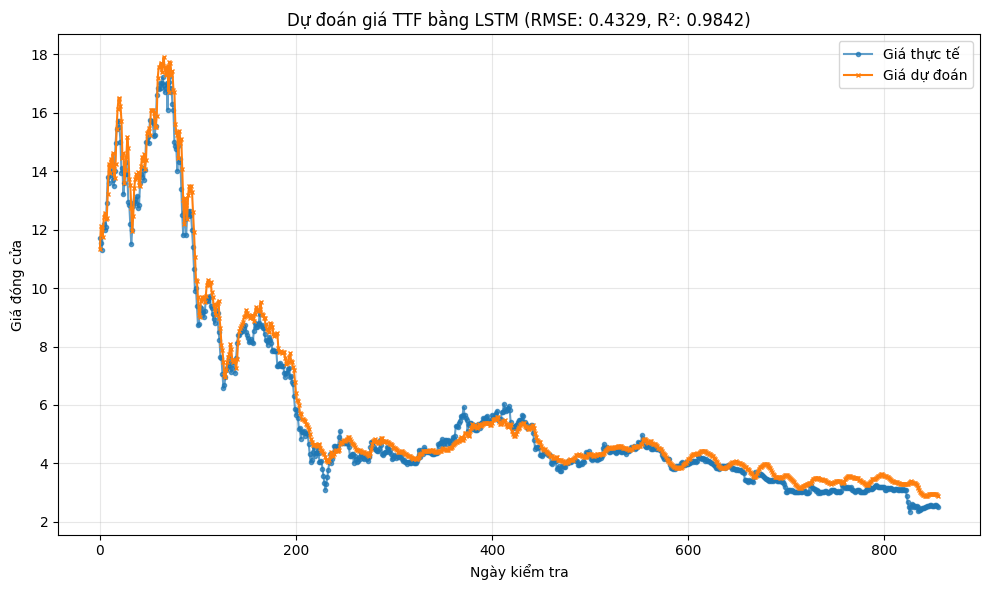

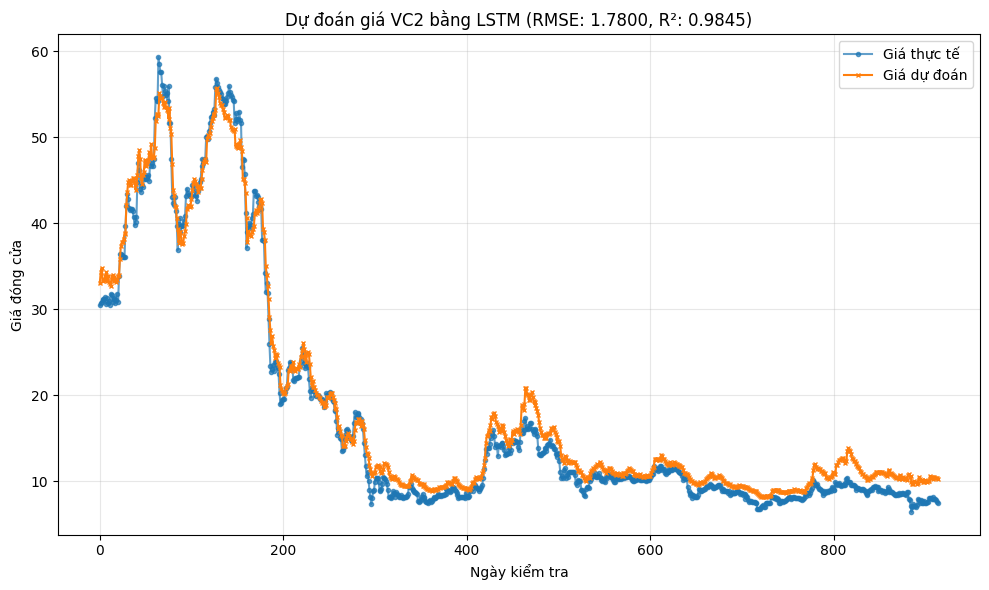

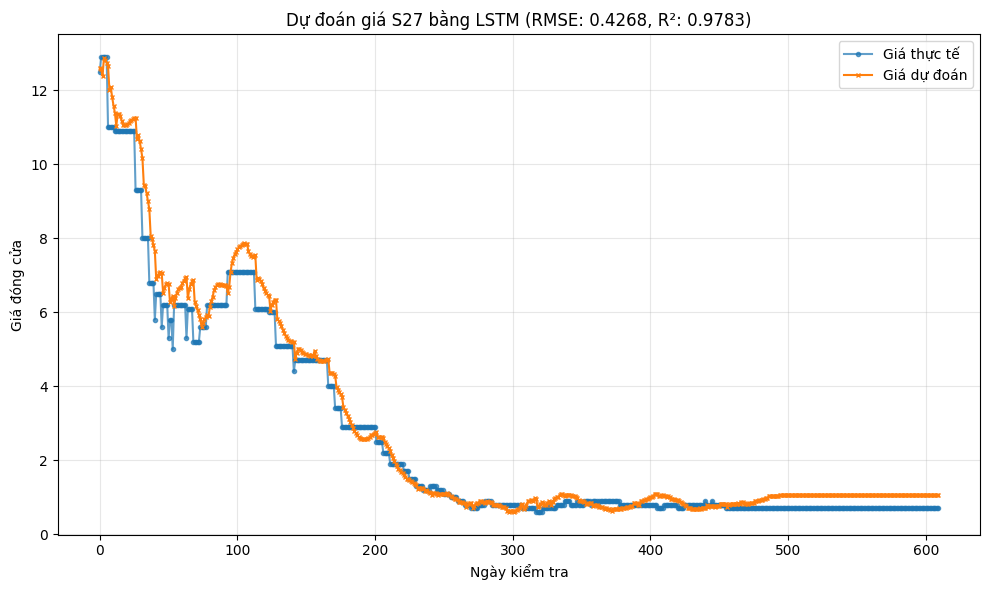

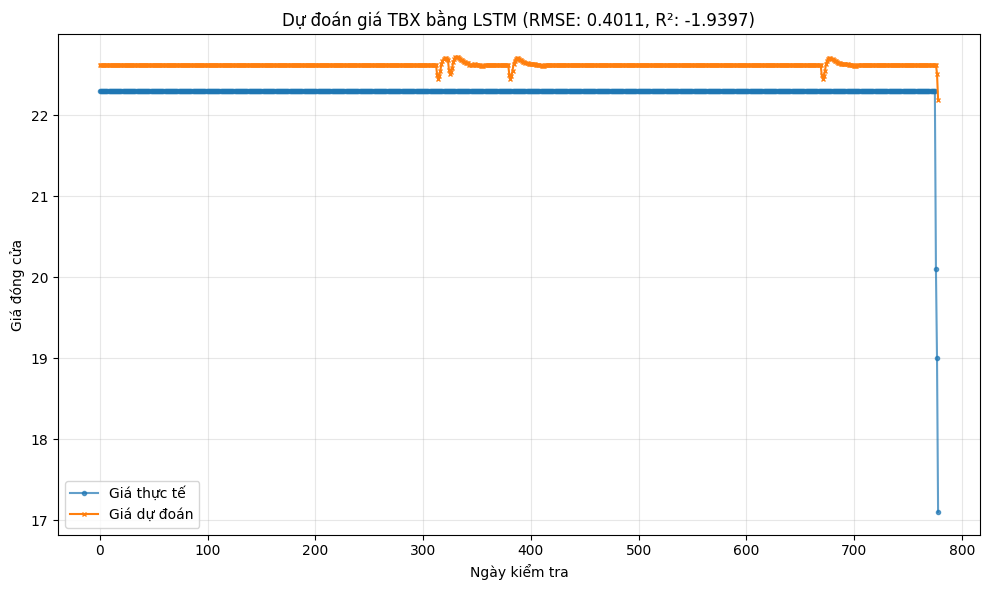

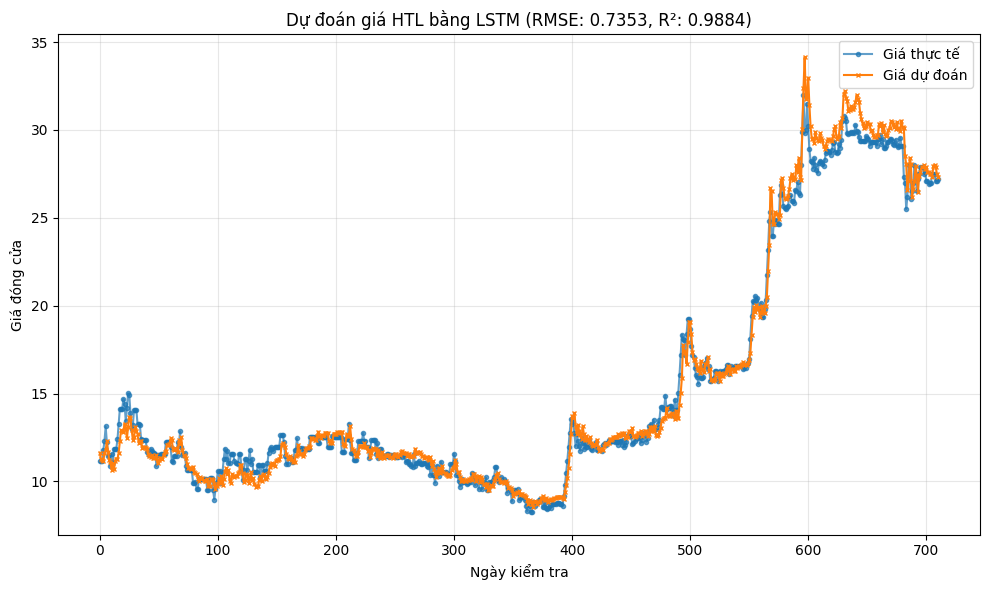

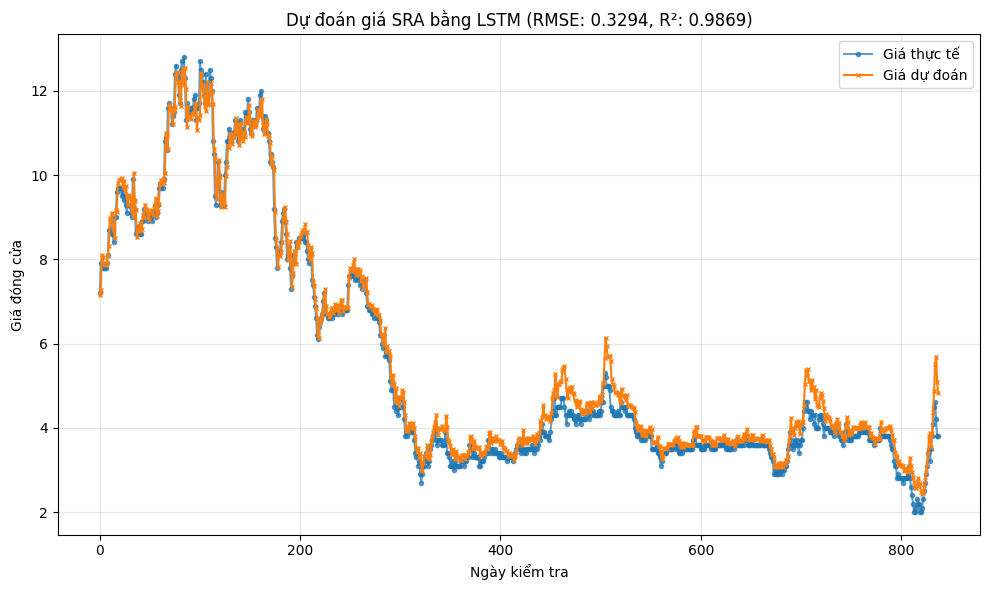

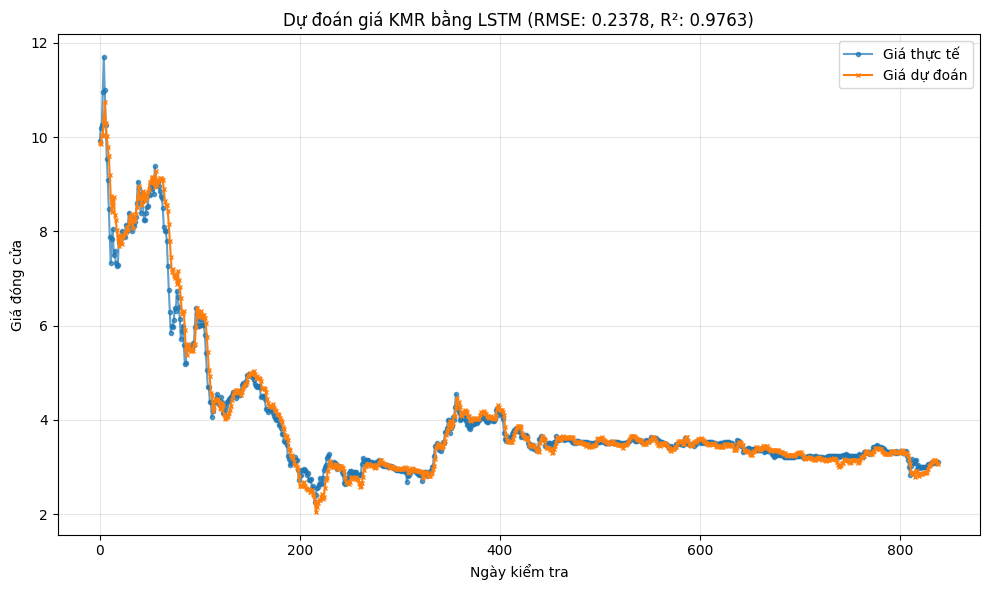

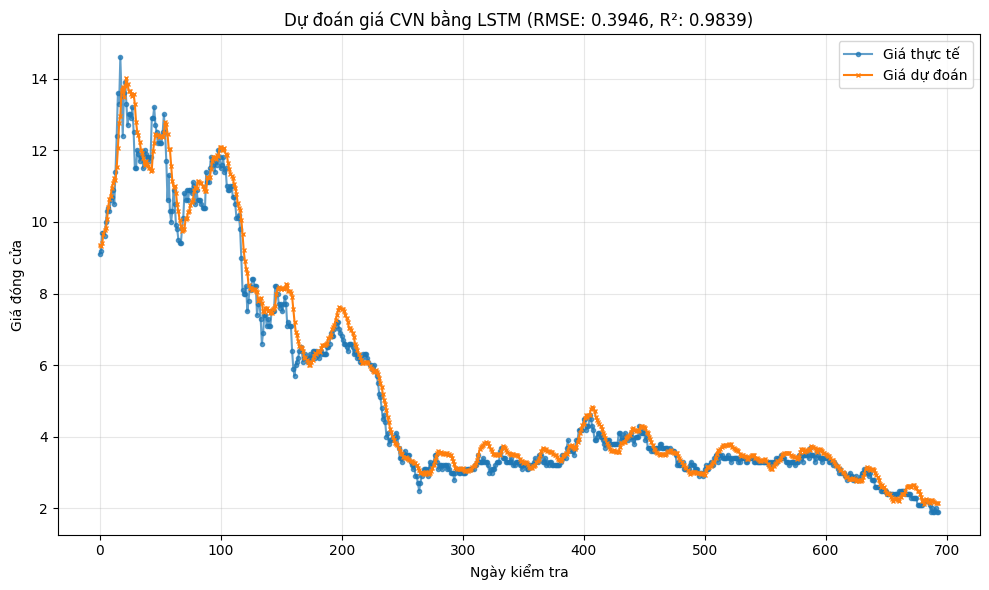

In [5]:
results = []

top_r2_tickers = load_tickers_from_file("top_r2_tickers.txt")
print(top_r2_tickers)
for ticker in top_r2_tickers:
    result = train_LSTM_enhanced(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy','total_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

RMSE TICKERS THAP NHAT

In [ ]:
results = []

low_rmse_tickers = load_tickers_from_file("lowest_rmse_tickers.txt")
print(low_rmse_tickers)
for ticker in low_rmse_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'test_days', 'train_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

['UMC', 'FCC', 'DPS', 'V11', 'ACM', 'NHP', 'HKB', 'CAD', 'G20', 'PVH']
⚠️ UMC có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ FCC có giá close không hợp lệ (âm hoặc bằng 0)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
⚠️ V11 có giá close không hợp lệ (âm hoặc bằng 0)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer i

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in 

⚠️ CAD có giá close không hợp lệ (âm hoặc bằng 0)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 6
R² trung bình: 0.7859
RMSE trung bình: 0.0588
Độ chính xác dự đoán hướng trung bình: 0.3863
  ticker      rmse        r2  direction_accuracy  total_days
0    DPS  0.068551  0.809584            0.314978        2305
1    ACM  0.049990  0.766259            0.427938        2289
2    NHP  0.057216  0.900846            0.183983        2341
3    HKB  0.076576  0.456882            0.330472        2362
4    G20  0.050678  0.844228            0.295745        2381
5    PVH  0.049497  0.937466            0.764543        1839
13517
10667
2670


2025-05-23 10:39:03,237 - INFO - Bắt đầu huấn luyện LSTM cho UMC sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:03,237 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23


['UMC', 'FCC', 'DPS', 'V11', 'ACM', 'NHP', 'HKB', 'CAD', 'G20', 'PVH']


2025-05-23 10:39:03,689 - INFO - Đã lấy được 1931 ngày dữ liệu cho UMC
2025-05-23 10:39:03,691 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:39:03,693 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-23 10:39:03,694 - INFO - Bắt đầu huấn luyện LSTM cho FCC sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:03,694 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:39:03,961 - INFO - Đã lấy được 2058 ngày dữ liệu cho FCC
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:39:03,963 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:39:03,964 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-23 10:39:03,964 - INFO - Bắt đầu huấn luyện LSTM cho DPS sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:03,964 - INFO - Đang lấy dữ liệu từ 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-23 10:39:24,759 - INFO - Kết quả dự đoán cho DPS: RMSE=0.4908, R²=-8.6609, Trend=UP (166.37%)
2025-05-23 10:39:24,760 - INFO - Bắt đầu huấn luyện LSTM cho V11 sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:24,760 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:39:25,066 - INFO - Đã lấy được 2915 ngày dữ liệu cho V11
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:39:25,069 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:39:25,069 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-23 10:39:25,070 - INFO - Bắt đầu huấn luyện LSTM cho ACM sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:25,070 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:39:25,371 - INFO - Đã lấy được 2290 ngày dữ liệu cho ACM
Setting an item of incompatible dtyp

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2025-05-23 10:39:49,569 - INFO - Kết quả dự đoán cho ACM: RMSE=0.3809, R²=-12.5634, Trend=UP (6.58%)
2025-05-23 10:39:49,571 - INFO - Bắt đầu huấn luyện LSTM cho NHP sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:39:49,571 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:39:49,959 - INFO - Đã lấy được 2341 ngày dữ liệu cho NHP
2025-05-23 10:39:49,959 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:39:49,978 - INFO - Phân chia dữ liệu: Train: 1617, Val: 231, Test: 463 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:39:50,040 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:40:31,287 - INFO - Đánh giá mô hình trên tập test


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2025-05-23 10:40:31,973 - INFO - Kết quả dự đoán cho NHP: RMSE=0.3047, R²=-1.8122, Trend=UP (126.72%)
2025-05-23 10:40:31,975 - INFO - Bắt đầu huấn luyện LSTM cho HKB sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:40:31,975 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:40:32,285 - INFO - Đã lấy được 2363 ngày dữ liệu cho HKB
2025-05-23 10:40:32,287 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:40:32,305 - INFO - Phân chia dữ liệu: Train: 1633, Val: 233, Test: 467 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:40:32,362 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:41:09,054 - INFO - Đánh giá mô hình trên tập test


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2025-05-23 10:41:09,688 - INFO - Kết quả dự đoán cho HKB: RMSE=0.4608, R²=-18.6437, Trend=UP (45.87%)
2025-05-23 10:41:09,688 - INFO - Bắt đầu huấn luyện LSTM cho CAD sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:41:09,688 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:41:09,978 - INFO - Đã lấy được 2969 ngày dữ liệu cho CAD
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:41:09,978 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:41:09,978 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close
2025-05-23 10:41:09,978 - INFO - Bắt đầu huấn luyện LSTM cho G20 sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:41:09,978 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:41:10,283 - INFO - Đã lấy được 2382 ngày dữ liệu cho G20
Setting an item of incompatible dtyp

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2025-05-23 10:41:39,767 - INFO - Kết quả dự đoán cho G20: RMSE=0.1439, R²=-0.2639, Trend=DOWN (-4.80%)
2025-05-23 10:41:39,769 - INFO - Bắt đầu huấn luyện LSTM cho PVH sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:41:39,770 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 10:41:40,098 - INFO - Đã lấy được 1840 ngày dữ liệu cho PVH
2025-05-23 10:41:40,100 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:41:40,124 - INFO - Phân chia dữ liệu: Train: 1267, Val: 181, Test: 362 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:41:40,185 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 10:42:13,287 - INFO - Đánh giá mô hình trên tập test


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-23 10:42:13,921 - INFO - Kết quả dự đoán cho PVH: RMSE=0.0824, R²=0.8271, Trend=UP (16.33%)



=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 6
R² trung bình: -6.8528
RMSE trung bình: 0.3106
Độ chính xác dự đoán hướng trung bình: 0.1934
  ticker      rmse         r2  direction_accuracy  total_days  test_days  \
0    DPS  0.490801  -8.660881            0.050549        2305        456   
1    ACM  0.380890 -12.563392            0.416851        2290        452   
2    NHP  0.304705  -1.812156            0.103896        2341        463   
3    HKB  0.460803 -18.643695            0.096567        2363        467   
4    G20  0.143852  -0.263890            0.176596        2382        471   
5    PVH  0.082380   0.827099            0.315789        1840        362   

   train_days  
0        1592  
1        1582  
2        1617  
3        1633  
4        1646  
5        1267  
13521
9337
2671


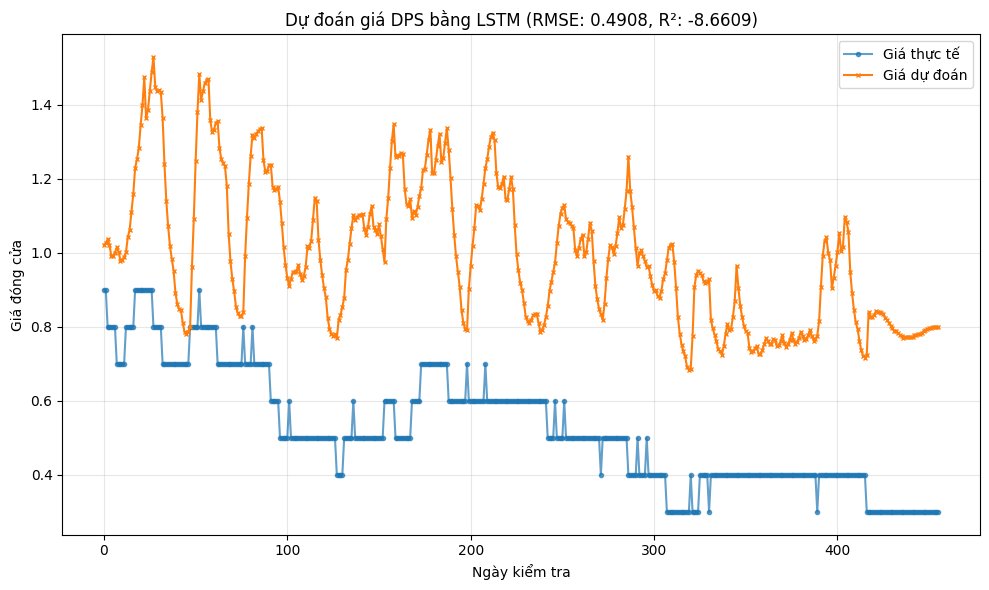

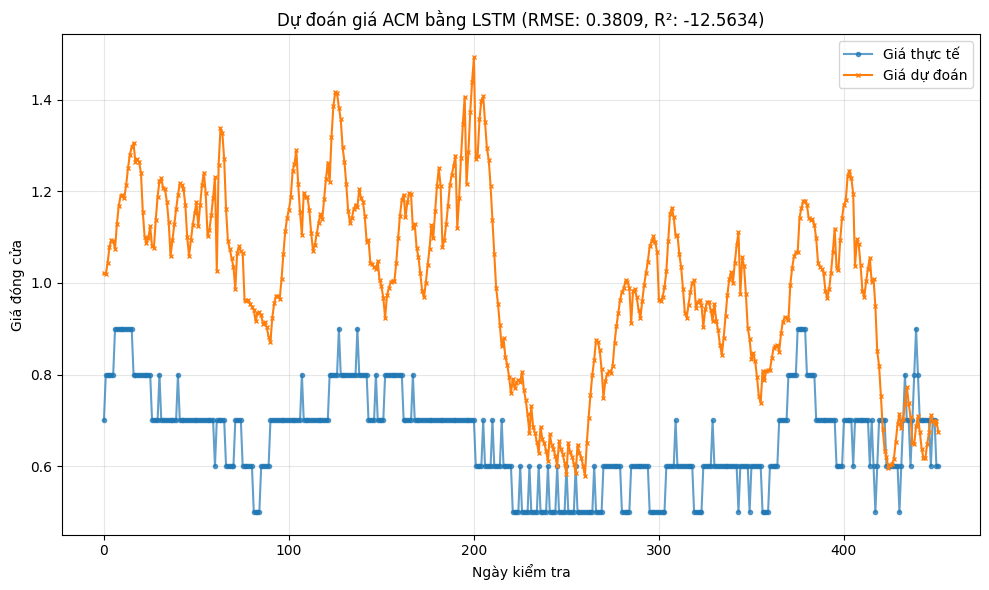

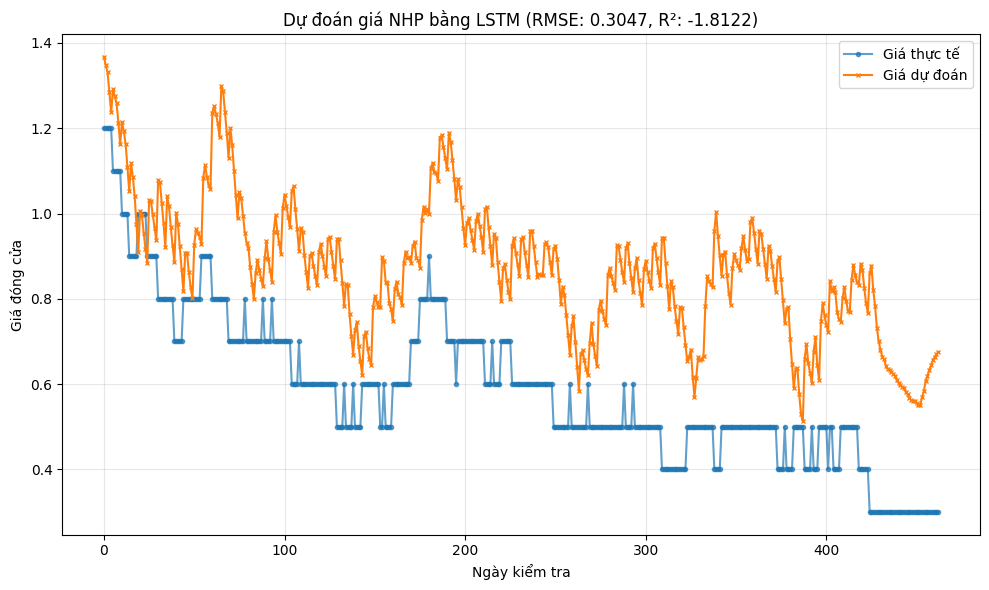

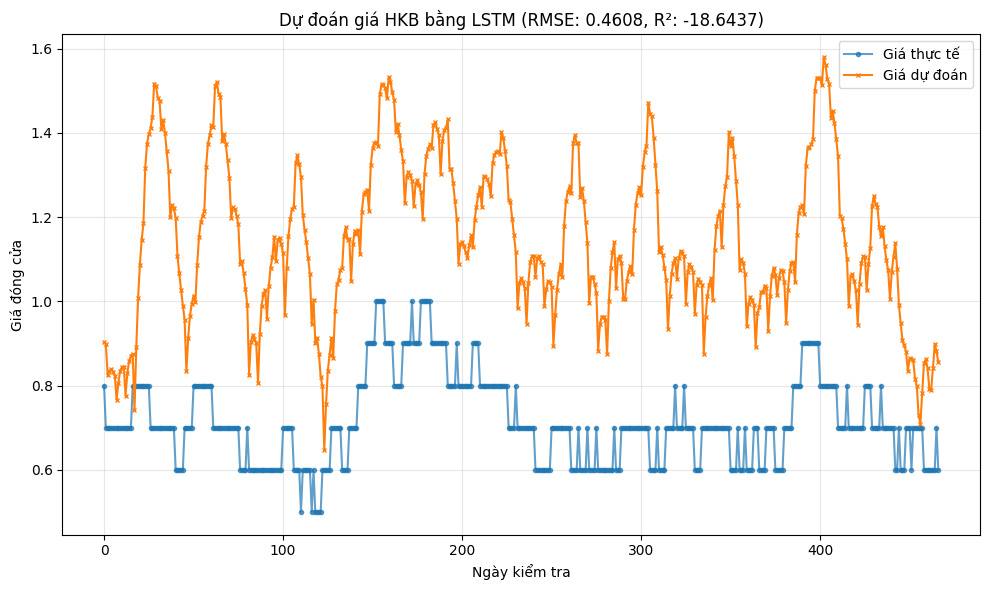

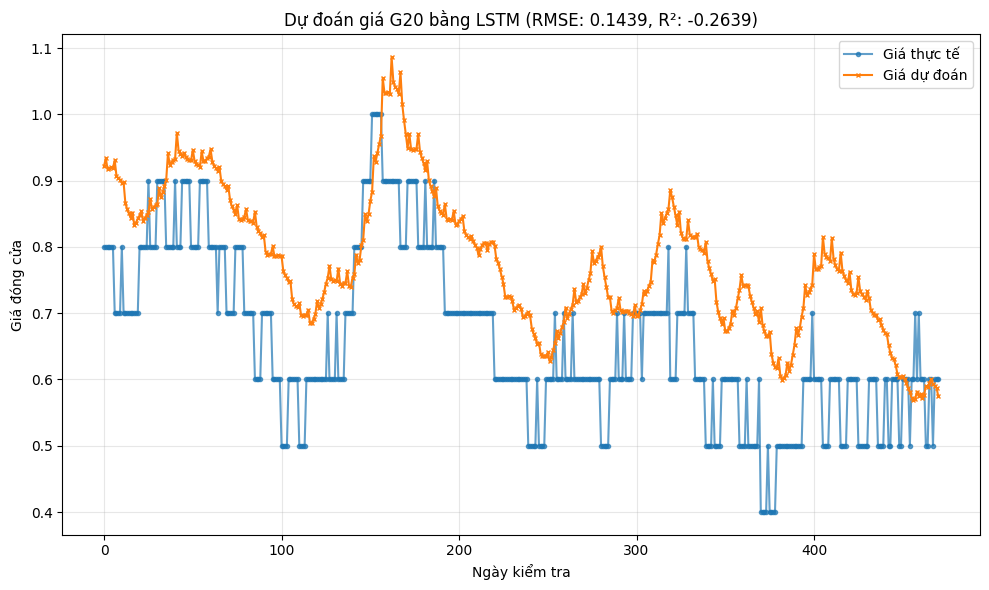

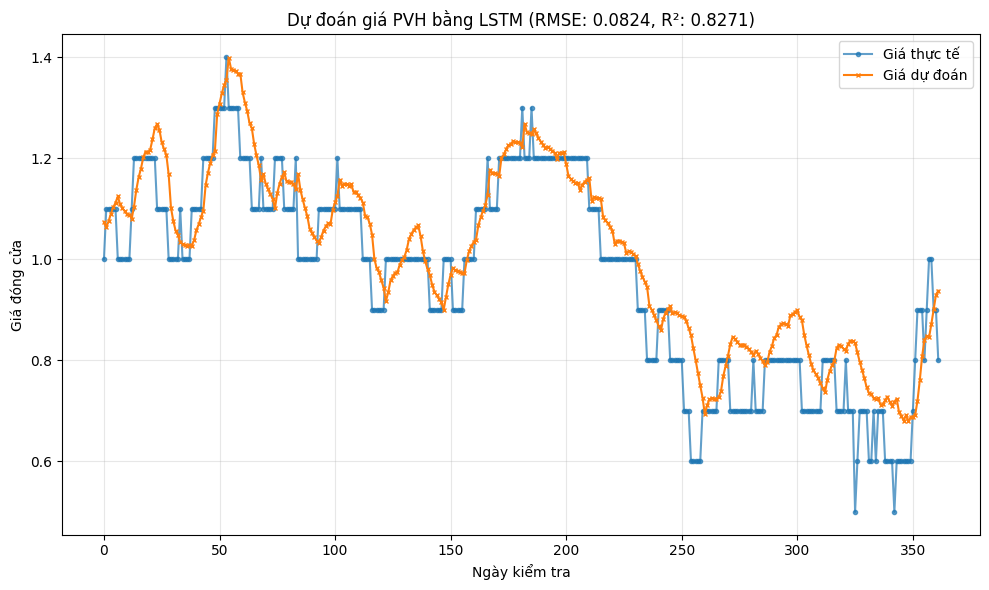

In [6]:
results = []

low_rmse_tickers = load_tickers_from_file("lowest_rmse_tickers.txt")
print(low_rmse_tickers)
for ticker in low_rmse_tickers:
    result = train_LSTM_enhanced(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'test_days', 'train_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

RMSE CAO NHAT

In [18]:
results = []

high_rmse_tickers = load_tickers_from_file("highest_rmse_tickers.txt")
print(high_rmse_tickers)
for ticker in high_rmse_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

['HGM', 'KSV', 'VE4', 'CMF', 'FRT', 'WCS', 'MCH', 'PDN', 'TOS', 'AGX']


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
⚠️ AGX có giá close không hợp lệ (âm hoặc bằng 0)

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 9
R² trung bình: 0.9637
RMSE trung bình: 9.0405
Độ chính xác dự đoán hướng trung bình: 0.5621
  ticker       rmse        r2  direction_accuracy  total_days
0    HGM  15.883857  0.966474            0.700787        3843
1    KSV  13.512932  0.959116            0.451389        2194
2    VE4   6.361411  0.994757            0.555938        2939
3    CMF  15.588533  0.935999            0.698795        2106
4    FRT   3.142394  0.983396            0.537572        1764
5    WCS   8.148068  0.984581            0.394958        3605
6    MCH   3.031451  0.994174            0.506083        2088
7    PDN   5.847358  0.936612            0.651719        3379
8    TOS   9.848429  0.918499            0.561798         921
22839
18052
4517


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01


2025-05-23 10:58:09,905 - INFO - Bắt đầu huấn luyện LSTM cho HGM sử dụng tất cả dữ liệu có sẵn
2025-05-23 10:58:09,906 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23


['HGM', 'KSV', 'VE4', 'CMF', 'FRT', 'WCS', 'MCH', 'PDN', 'TOS', 'AGX']


2025-05-23 10:58:11,648 - INFO - Đã lấy được 3845 ngày dữ liệu cho HGM
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 10:58:11,651 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 10:58:11,681 - INFO - Phân chia dữ liệu: Train: 2670, Val: 381, Test: 764 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 10:58:11,770 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:00:18,883 - INFO - Đánh giá mô hình trên tập test


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2025-05-23 11:00:19,882 - INFO - Kết quả dự đoán cho HGM: RMSE=87.0486, R²=0.0075, Trend=DOWN (-79.25%)
2025-05-23 11:00:19,883 - INFO - Bắt đầu huấn luyện LSTM cho KSV sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:00:19,884 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:00:20,200 - INFO - Đã lấy được 2197 ngày dữ liệu cho KSV
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:00:20,203 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:00:20,228 - INFO - Phân chia dữ liệu: Train: 1516, Val: 216, Test: 435 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:00:20,351 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:00:47,823 - INFO - Đánh g

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2025-05-23 11:00:48,671 - INFO - Kết quả dự đoán cho KSV: RMSE=63.5795, R²=0.1063, Trend=DOWN (-63.74%)
2025-05-23 11:00:48,672 - INFO - Bắt đầu huấn luyện LSTM cho VE4 sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:00:48,674 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:00:49,121 - INFO - Đã lấy được 2939 ngày dữ liệu cho VE4
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:00:49,124 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:00:49,155 - INFO - Phân chia dữ liệu: Train: 2036, Val: 290, Test: 583 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:00:49,222 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:01:19,764 - INFO - Đánh g

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2025-05-23 11:01:20,510 - INFO - Kết quả dự đoán cho VE4: RMSE=99.4487, R²=-0.2815, Trend=DOWN (-37.71%)
2025-05-23 11:01:20,511 - INFO - Bắt đầu huấn luyện LSTM cho CMF sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:01:20,512 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:01:21,084 - INFO - Đã lấy được 2106 ngày dữ liệu cho CMF
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:01:21,087 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:01:21,107 - INFO - Phân chia dữ liệu: Train: 1453, Val: 207, Test: 416 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:01:21,166 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:02:26,524 - INFO - Đánh 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


2025-05-23 11:02:27,160 - INFO - Kết quả dự đoán cho CMF: RMSE=24.5467, R²=0.8412, Trend=DOWN (-10.57%)
2025-05-23 11:02:27,162 - INFO - Bắt đầu huấn luyện LSTM cho FRT sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:02:27,162 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:02:27,468 - INFO - Đã lấy được 1767 ngày dữ liệu cho FRT
2025-05-23 11:02:27,487 - INFO - Phân chia dữ liệu: Train: 1215, Val: 173, Test: 349 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:02:27,549 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:02:50,320 - INFO - Đánh giá mô hình trên tập test


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2025-05-23 11:02:51,010 - INFO - Kết quả dự đoán cho FRT: RMSE=37.0506, R²=-1.3651, Trend=DOWN (-18.79%)
2025-05-23 11:02:51,011 - INFO - Bắt đầu huấn luyện LSTM cho WCS sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:02:51,012 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:02:51,566 - INFO - Đã lấy được 3608 ngày dữ liệu cho WCS
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:02:51,571 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:02:51,593 - INFO - Phân chia dữ liệu: Train: 2504, Val: 357, Test: 717 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:02:51,650 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:04:35,165 - INFO - Đánh 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2025-05-23 11:04:35,922 - INFO - Kết quả dự đoán cho WCS: RMSE=28.3204, R²=0.8173, Trend=DOWN (-5.97%)
2025-05-23 11:04:35,925 - INFO - Bắt đầu huấn luyện LSTM cho MCH sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:04:35,926 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:04:36,185 - INFO - Đã lấy được 2091 ngày dữ liệu cho MCH
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:04:36,187 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:04:36,206 - INFO - Phân chia dữ liệu: Train: 1442, Val: 206, Test: 413 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:04:36,273 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:05:19,308 - INFO - Đánh gi

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2025-05-23 11:05:20,095 - INFO - Kết quả dự đoán cho MCH: RMSE=24.5619, R²=0.6130, Trend=DOWN (-21.30%)
2025-05-23 11:05:20,097 - INFO - Bắt đầu huấn luyện LSTM cho PDN sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:05:20,098 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:05:20,631 - INFO - Đã lấy được 3380 ngày dữ liệu cho PDN
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:05:20,632 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:05:20,656 - INFO - Phân chia dữ liệu: Train: 2345, Val: 335, Test: 670 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:05:20,727 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:06:30,272 - INFO - Đánh g

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


2025-05-23 11:06:31,972 - INFO - Kết quả dự đoán cho PDN: RMSE=12.5250, R²=0.7086, Trend=DOWN (-3.14%)
2025-05-23 11:06:31,973 - INFO - Bắt đầu huấn luyện LSTM cho TOS sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:06:31,974 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:06:32,331 - INFO - Đã lấy được 924 ngày dữ liệu cho TOS
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:06:32,334 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:06:32,354 - INFO - Phân chia dữ liệu: Train: 625, Val: 89, Test: 180 mẫu
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-05-23 11:06:32,423 - INFO - Bắt đầu huấn luyện mô hình LSTM
2025-05-23 11:06:48,373 - INFO - Đánh giá m

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2025-05-23 11:06:48,988 - INFO - Kết quả dự đoán cho TOS: RMSE=15.6150, R²=0.7972, Trend=UP (2.04%)
2025-05-23 11:06:48,990 - INFO - Bắt đầu huấn luyện LSTM cho AGX sử dụng tất cả dữ liệu có sẵn
2025-05-23 11:06:48,990 - INFO - Đang lấy dữ liệu từ 2000-01-01 đến 2025-05-23
2025-05-23 11:06:49,646 - INFO - Đã lấy được 2423 ngày dữ liệu cho AGX
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
2025-05-23 11:06:49,650 - WARNING - Đã điều chỉnh 0 giá trị volume không hợp lệ
2025-05-23 11:06:49,651 - ERROR - Phát hiện giá trị giá không hợp lệ trong cột close



=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 9
R² trung bình: 0.2494
RMSE trung bình: 43.6329
Độ chính xác dự đoán hướng trung bình: 0.6034
  ticker       rmse        r2  direction_accuracy  total_days  test_days  \
0    HGM  87.048556  0.007460            0.750983        3845        764   
1    KSV  63.579463  0.106279            0.573733        2197        435   
2    VE4  99.448660 -0.281498            0.951890        2939        583   
3    CMF  24.546662  0.841153            0.609639        2106        416   
4    FRT  37.050642 -1.365055            0.540230        1767        349   
5    WCS  28.320361  0.817333            0.500000        3608        717   
6    MCH  24.561908  0.612989            0.507282        2091        413   
7    PDN  12.525028  0.708624            0.482810        3380        670   
8    TOS  15.615000  0.797209            0.513966         924        180   

   train_days  
0        2670  
1        1516  
2        2036  
3        1453  
4        

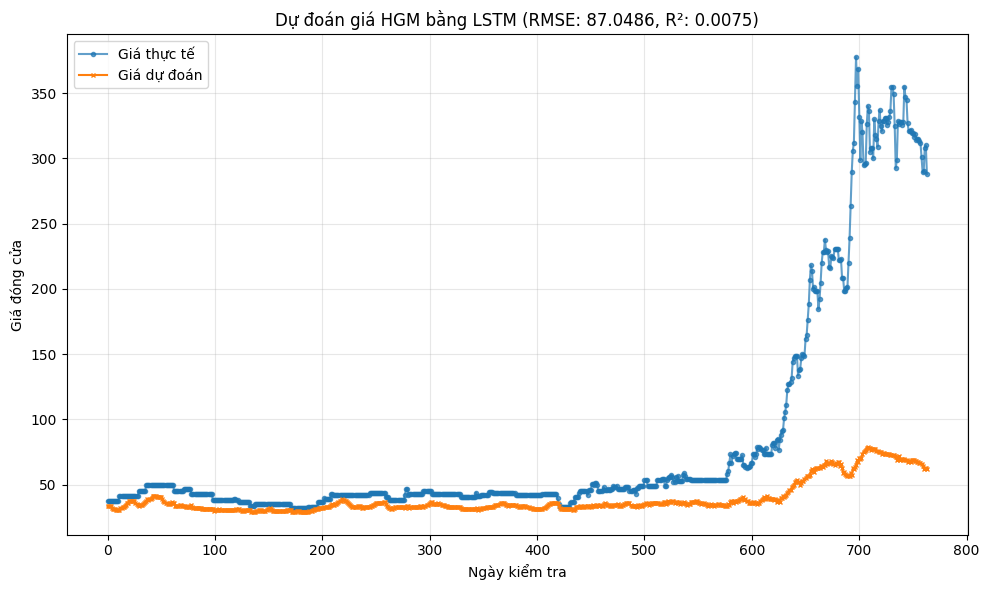

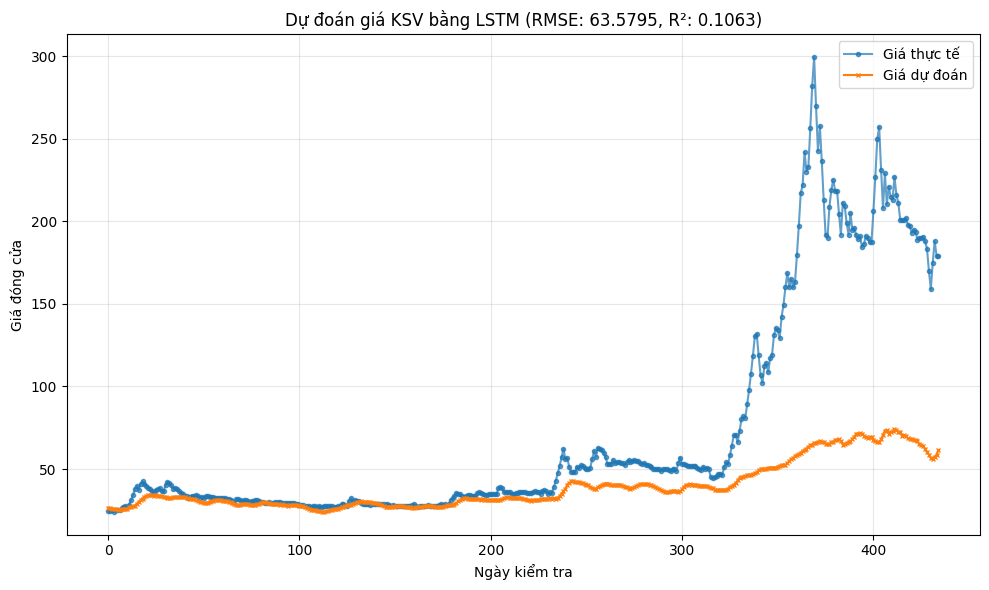

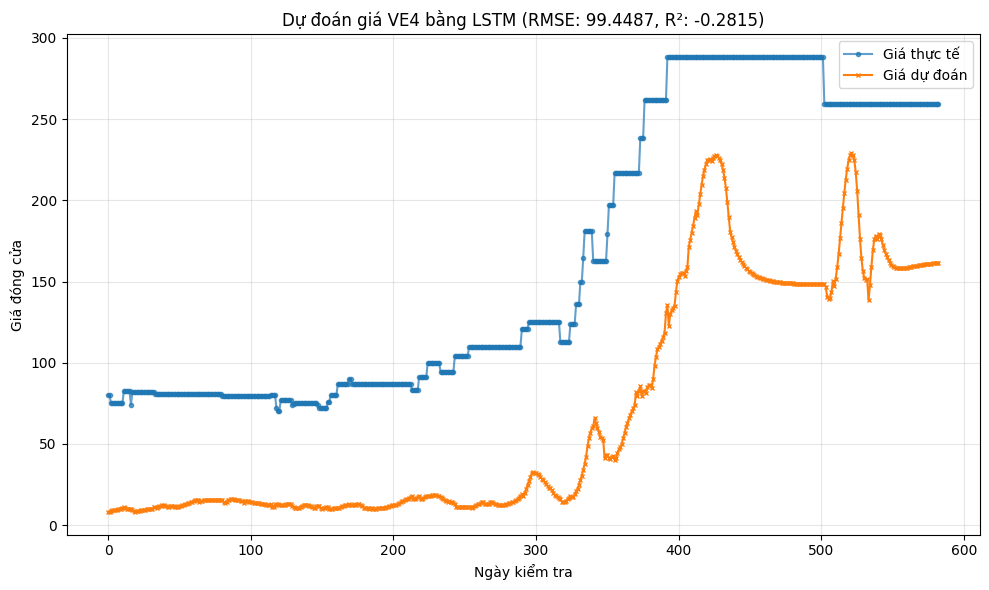

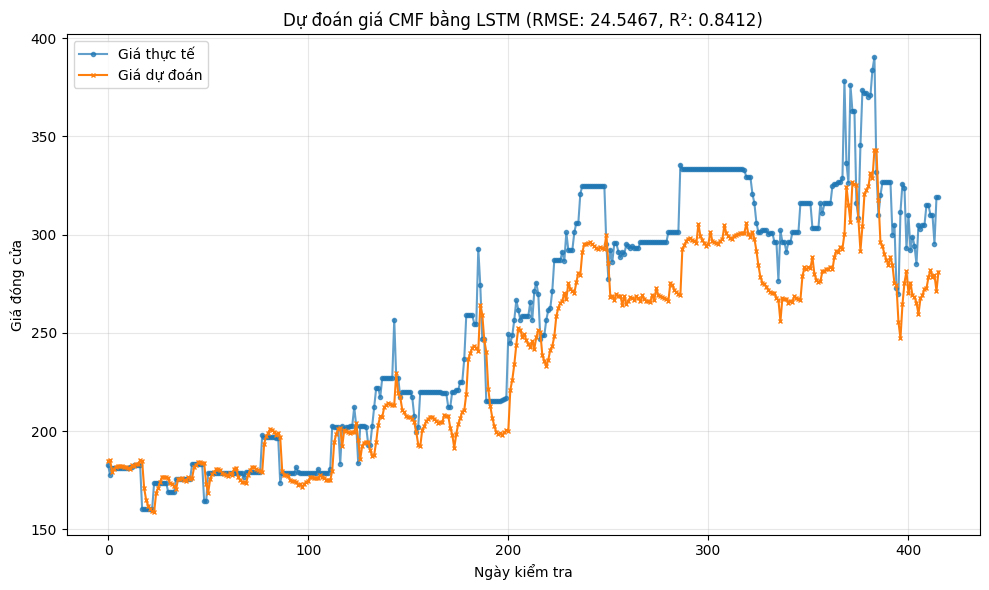

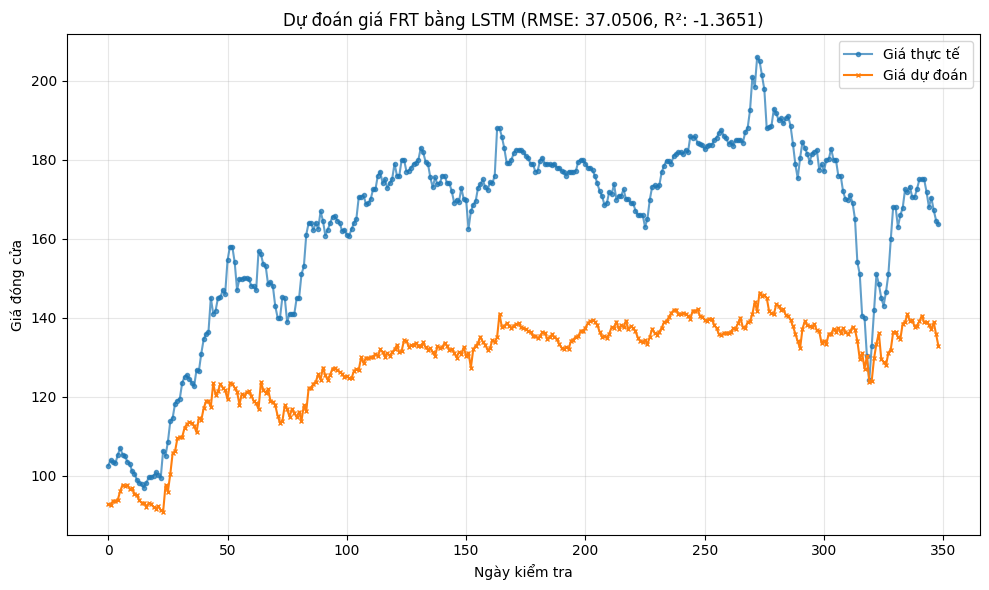

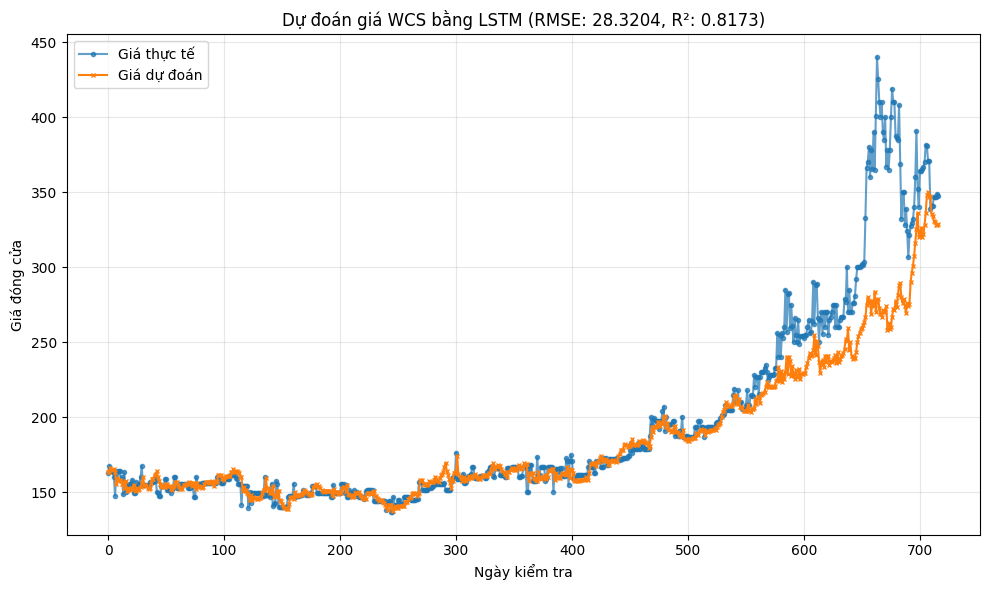

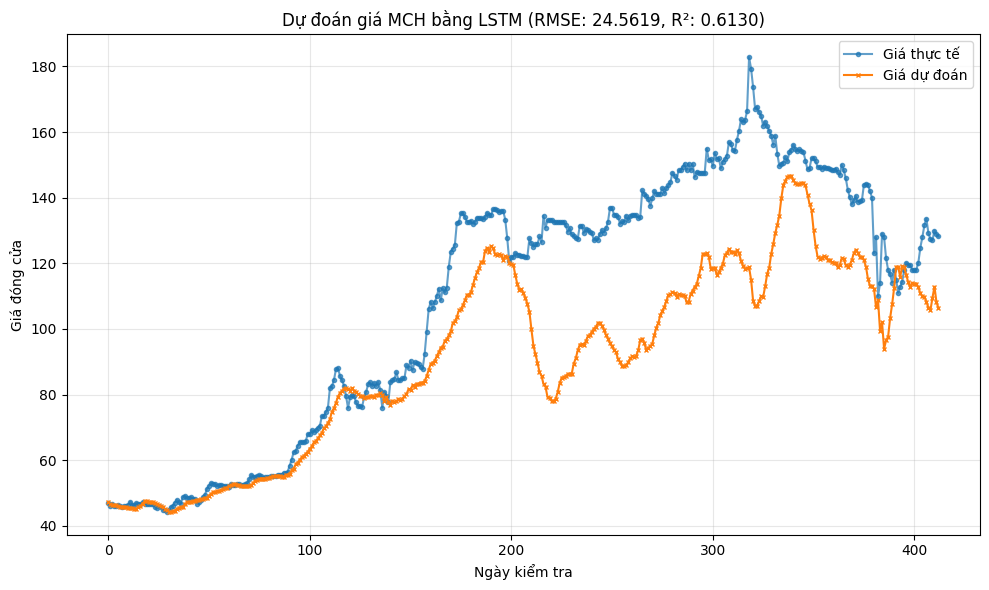

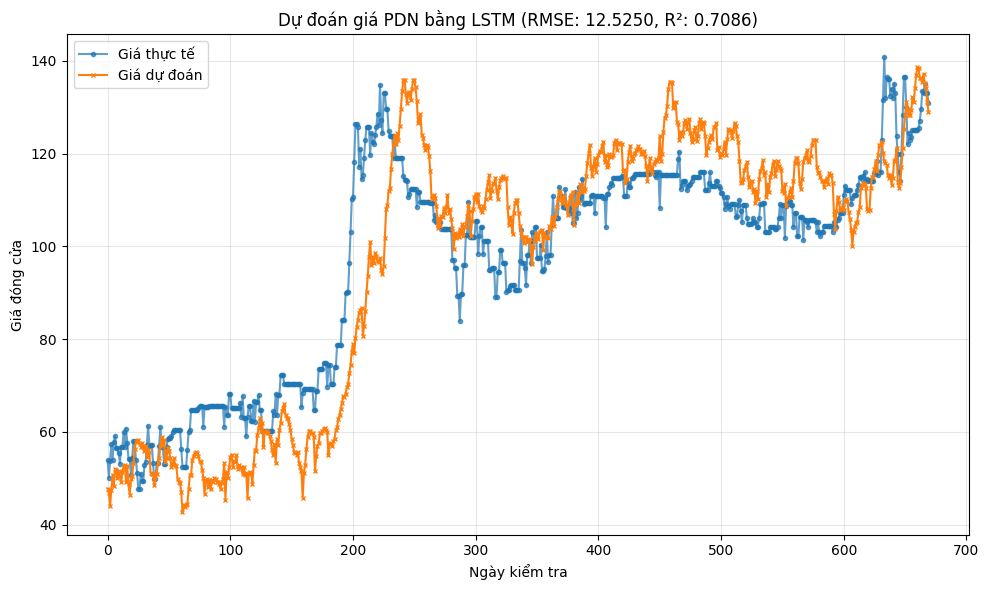

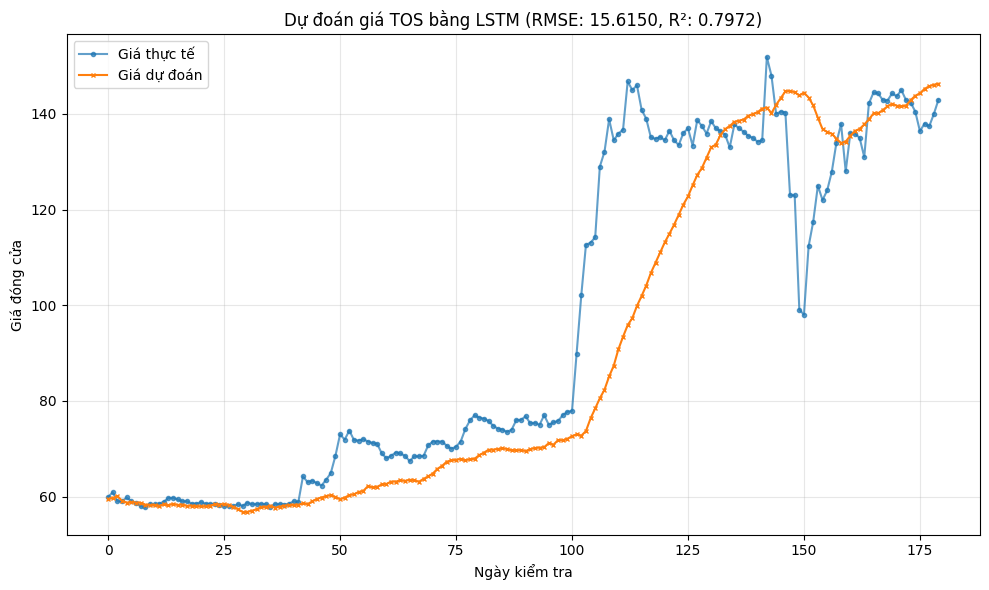

In [7]:
results = []

high_rmse_tickers = load_tickers_from_file("highest_rmse_tickers.txt")
print(high_rmse_tickers)
for ticker in high_rmse_tickers:
    result = train_LSTM_enhanced(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'test_days', 'train_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

Directional Acc Thap nhat

In [19]:
results = []

low_dir_tickers = load_tickers_from_file("lowest_dir_accuracy_tickers.txt")
print(low_dir_tickers)
for ticker in low_dir_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06' has dtype incompatible with int64, please explicitly c

['FCC', 'BHG', 'CDG', 'UMC', 'TQN', 'DKC', 'SDX', 'MPT', 'FGL', 'RCD']
⚠️ FCC có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ BHG có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ CDG có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ UMC có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ TQN có giá close không hợp lệ (âm hoặc bằng 0)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
⚠️ SDX có giá close không hợp lệ (âm hoặc bằng 0)


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
⚠️ FGL có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ RCD có giá close không hợp lệ (âm hoặc bằng 0)

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 2
R² trung bình: 0.4684
RMSE trung bình: 0.0619
Độ chính xác dự đoán hướng trung bình: 0.7667
  ticker      rmse        r2  direction_accuracy  total_days
0    DKC  0.042041  0.587706            0.964286        1011
1    MPT  0.081788  0.349110            0.569087        2166
3177
2492
625


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01


['FCC', 'BHG', 'CDG', 'UMC', 'TQN', 'DKC', 'SDX', 'MPT', 'FGL', 'RCD']
⚠️ FCC có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ BHG có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ CDG có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ UMC có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ TQN có giá close không hợp lệ (âm hoặc bằng 0)


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


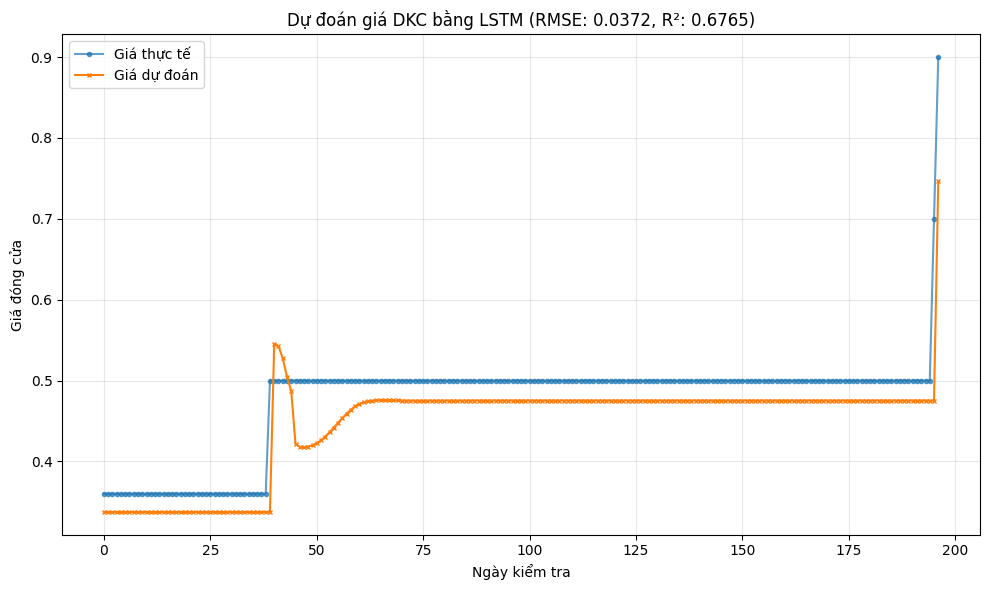

⚠️ SDX có giá close không hợp lệ (âm hoặc bằng 0)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


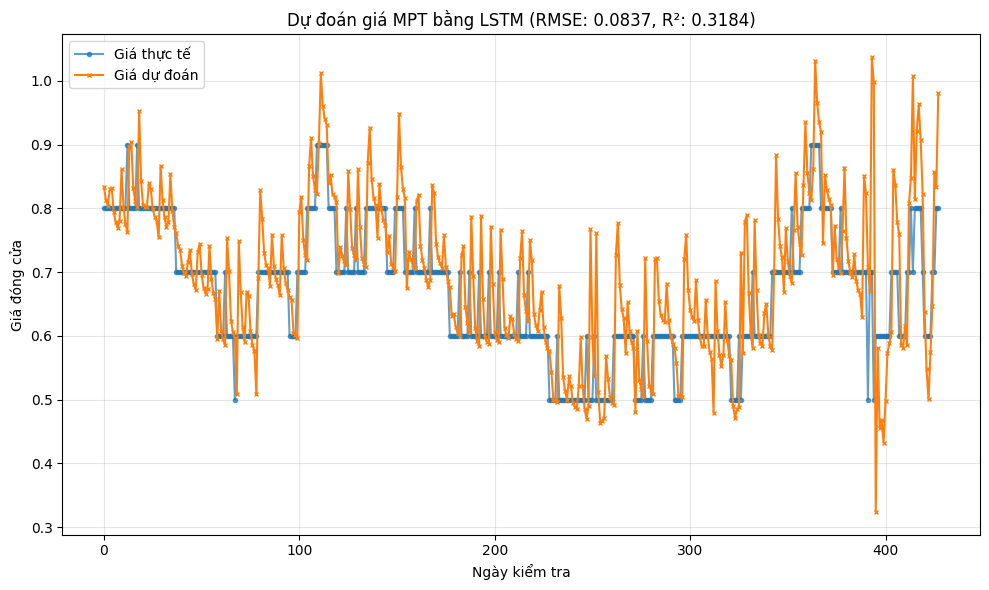

⚠️ FGL có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ RCD có giá close không hợp lệ (âm hoặc bằng 0)

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 2
R² trung bình: 0.4974
RMSE trung bình: 0.0605
Độ chính xác dự đoán hướng trung bình: 0.6603
  ticker      rmse        r2  direction_accuracy  total_days  test_days  \
0    DKC  0.037241  0.676468            0.969388        1011        197   
1    MPT  0.083694  0.318417            0.351288        2166        428   

   train_days  
0         784  
1        1708  
3177
2492
625


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [10]:
results = []

low_dir_tickers = load_tickers_from_file("lowest_dir_accuracy_tickers.txt")
print(low_dir_tickers)
for ticker in low_dir_tickers:
    result = train(ticker)
    if result:
        results.append(result)

# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'test_days', 'train_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

Directional Accuracy cao nhat

In [20]:
results = []

high_dir_tickers = load_tickers_from_file("highest_dir_accuracy_tickers.txt")
print(high_dir_tickers)
for ticker in high_dir_tickers:
    result = train(ticker)
    if result:
        results.append(result)


# Tạo DataFrame từ kết quả
result_df = pd.DataFrame(results)

# Hiển thị kết quả tổng hợp
print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())

['MEF', 'NQT', 'PTG', 'MTB', 'NAC', 'MND', 'HLT', 'QNU', 'VXP', 'GH3']
⚠️ MEF có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ NQT có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ PTG có giá close không hợp lệ (âm hoặc bằng 0)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly ca

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
⚠️ MND có giá close không hợp lệ (âm hoặc bằng 0)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9204\788956016.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features.loc[df_features['volume'] <= 0, 'volume'] = min_positive_volume * 0.01
c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
⚠️ QNU có giá close không hợp lệ (âm hoặc bằng 0)


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\ADMIN\miniconda3\envs\stockqa\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 5
R² trung bình: -157268130452735406920171520.0000
RMSE trung bình: 0.3148
Độ chính xác dự đoán hướng trung bình: 0.5856
  ticker      rmse            r2  direction_accuracy  total_days
0    MTB  0.076273 -4.609199e+26            1.000000         903
1    NAC  0.023485  9.644980e-01            0.839779        1841
2    HLT  1.299436  6.995321e-01            0.081081        1143
3    VXP  0.128178 -3.254207e+26            0.987500        1235
4    GH3  0.046650 -4.240802e+01            0.019868         790
5912
4608
1154


['MEF', 'NQT', 'PTG', 'MTB', 'NAC', 'MND', 'HLT', 'QNU', 'VXP', 'GH3']
⚠️ MEF có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ NQT có giá close không hợp lệ (âm hoặc bằng 0)
⚠️ PTG có giá close không hợp lệ (âm hoặc bằng 0)


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


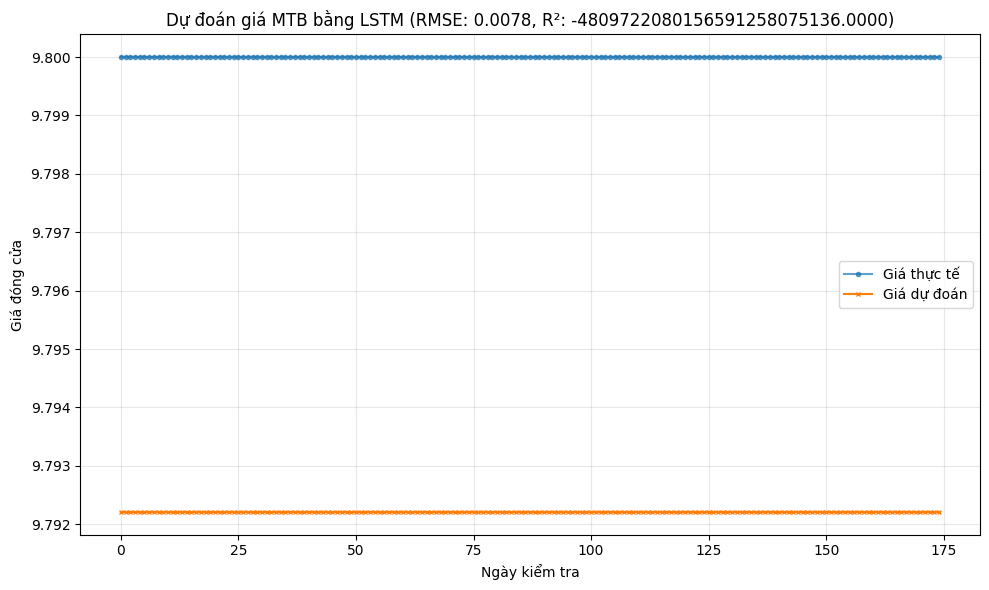

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


2025-05-23 11:51:40,087 - WARNING - 5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024D23971120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


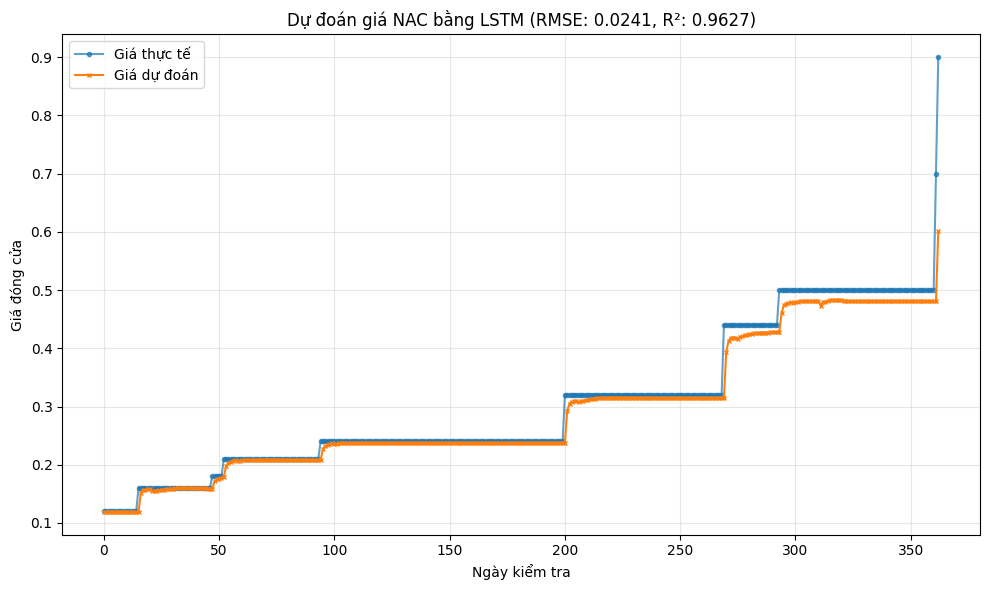

⚠️ MND có giá close không hợp lệ (âm hoặc bằng 0)


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


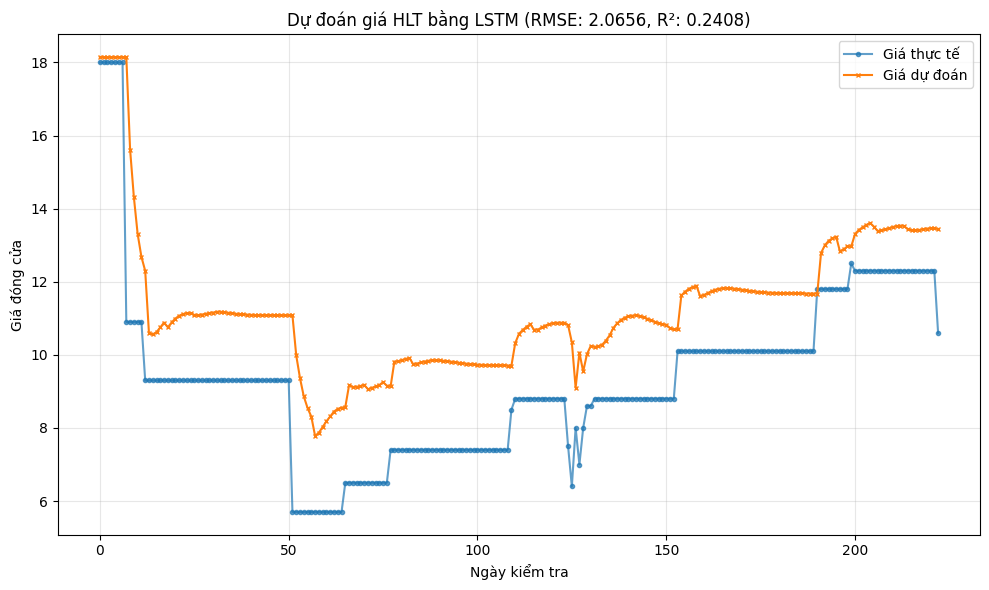

⚠️ QNU có giá close không hợp lệ (âm hoặc bằng 0)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


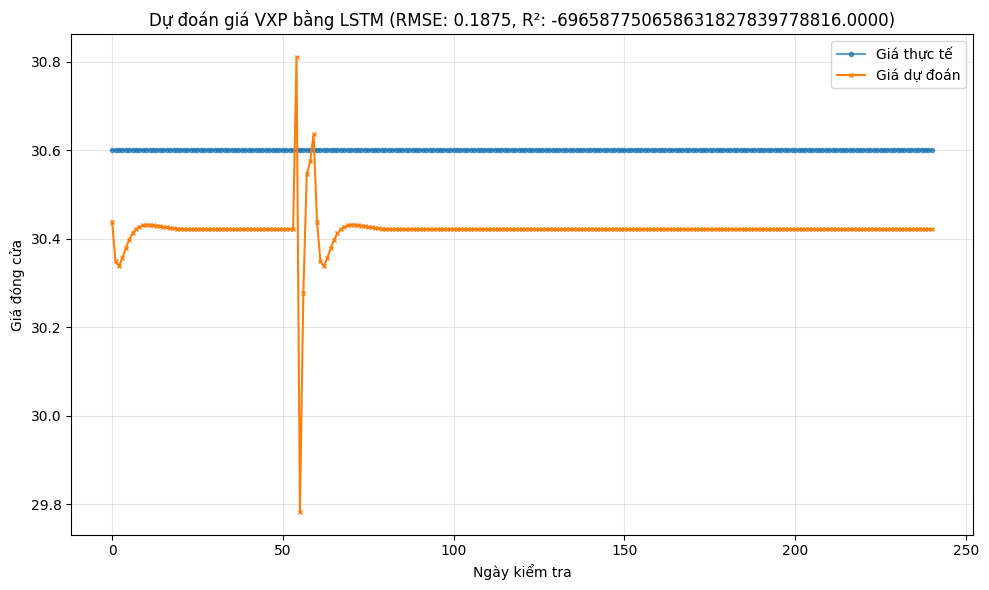

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


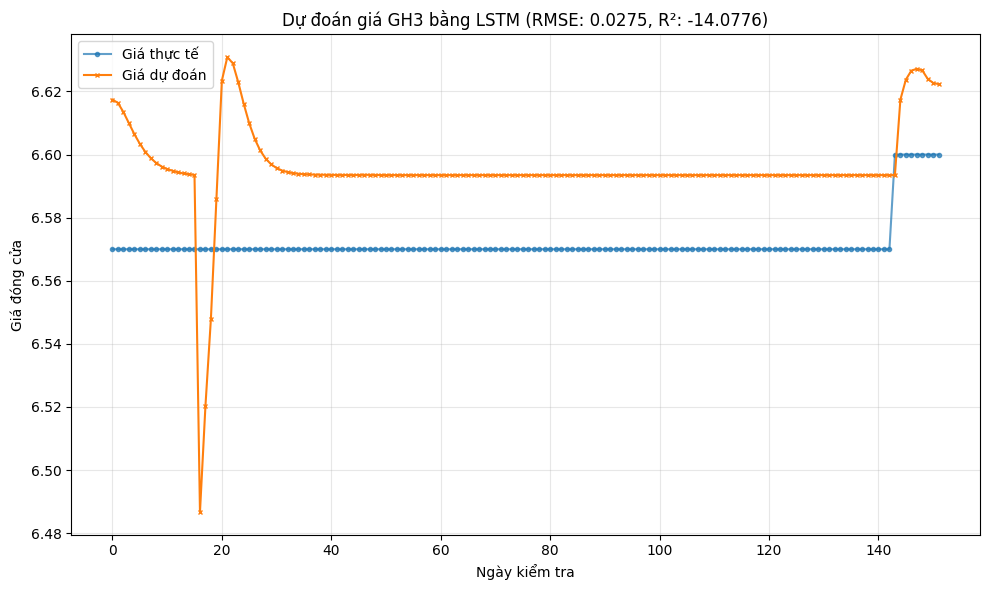


=== KẾT QUẢ TỔNG HỢP ===
Tổng số mã xử lý thành công: 5
R² trung bình: -140279494547757663311101952.0000
RMSE trung bình: 0.4625
Độ chính xác dự đoán hướng trung bình: 0.6086
  ticker      rmse            r2  direction_accuracy  total_days  test_days  \
0    MTB  0.007791 -4.809722e+24            1.000000         903        175   
1    NAC  0.024085  9.626597e-01            0.975138        1841        363   
2    HLT  2.065603  2.407553e-01            0.049550        1143        223   
3    VXP  0.187533 -6.965878e+26            0.991667        1235        241   
4    GH3  0.027494 -1.407765e+01            0.026490         790        152   

   train_days  
0         698  
1        1448  
2         890  
3         964  
4         608  
5912
4608
1154


In [11]:
results = []

high_dir_tickers = load_tickers_from_file("highest_dir_accuracy_tickers.txt")
print(high_dir_tickers)
for ticker in high_dir_tickers:
    result = train(ticker)
    if result:
        results.append(result)

result_df = pd.DataFrame(results)

print("\n=== KẾT QUẢ TỔNG HỢP ===")
print(f"Tổng số mã xử lý thành công: {len(result_df)}")
print(f"R² trung bình: {result_df['r2'].mean():.4f}")
print(f"RMSE trung bình: {result_df['rmse'].mean():.4f}")
print(f"Độ chính xác dự đoán hướng trung bình: {result_df['direction_accuracy'].mean():.4f}")
print(result_df[['ticker', 'rmse', 'r2', 'direction_accuracy', 'total_days', 'test_days', 'train_days']])
print(result_df["total_days"].sum())
print(result_df["train_days"].sum())
print(result_df["test_days"].sum())